In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_2048_1024_512_256_128_0001_CCE_7_1_1_0_1_0_e_e_0_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_0_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4339345, 828)
(4339345, 8)
validation
(669326, 828)
(669326, 8)
test
(492897, 828)
(492897, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 2048)              1697792   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 4486024 (17.11 MB)


Trainable params: 4486024 (17.11 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

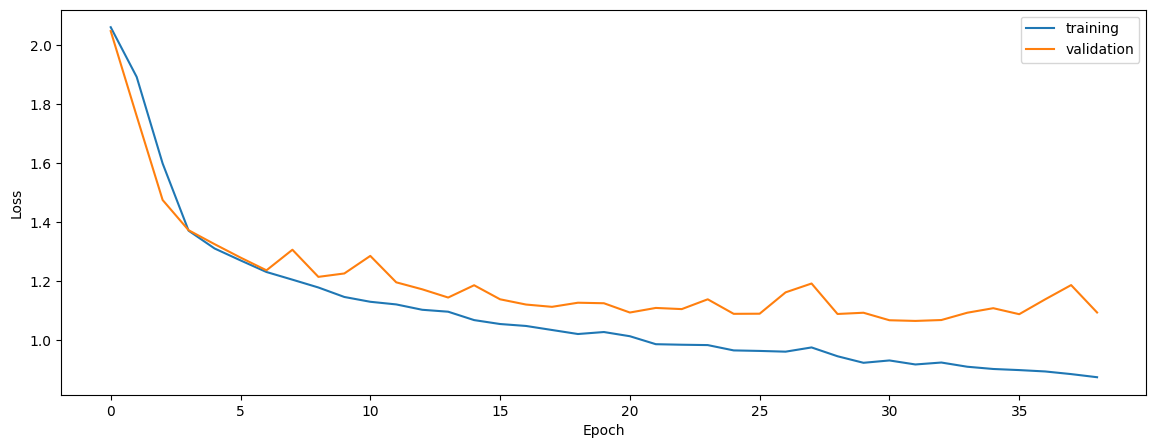

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True
props['collapse_bin'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'BCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_2048_1024_512_256_128_0001_BCE_7_1_0_1_1_1_0_e_e_0_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_0_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1160792, 828)
(1160792, 1)
validation
(184723, 828)
(184723, 1)
test
(137164, 828)
(137164, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_6 (Dense)             (None, 2048)              1697792   


 dense_7 (Dense)             (None, 1024)              2098176   


 dense_8 (Dense)             (None, 512)               524800    


 dense_9 (Dense)             (None, 256)               131328    


 dense_10 (Dense)            (None, 128)               32896     


 dense_11 (Dense)            (None, 1)                 129       


Total params: 4485121 (17.11 MB)


Trainable params: 4485121 (17.11 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/12 [=>............................] - ETA: 1:58 - loss: 0.9713 - STD: 2.6638e-05 - MAE: 0.5565

 2/12 [====>.........................] - ETA: 4s - loss: 0.8342 - STD: 8.4440e-05 - MAE: 0.5292  

 3/12 [======>.......................] - ETA: 3s - loss: 0.7827 - STD: 8.1926e-05 - MAE: 0.5063

 4/12 [=========>....................] - ETA: 3s - loss: 0.7686 - STD: 6.9690e-05 - MAE: 0.4906

 5/12 [===========>..................] - ETA: 3s - loss: 0.7634 - STD: 5.9951e-05 - MAE: 0.4803

 6/12 [==============>...............] - ETA: 2s - loss: 0.7578 - STD: 5.3296e-05 - MAE: 0.4739

 7/12 [================>.............] - ETA: 2s - loss: 0.7507 - STD: 4.8761e-05 - MAE: 0.4703

 8/12 [===================>..........] - ETA: 1s - loss: 0.7425 - STD: 4.5497e-05 - MAE: 0.4689

 9/12 [=====================>........] - ETA: 1s - loss: 0.7346 - STD: 4.2892e-05 - MAE: 0.4689

10/12 [========================>.....] - ETA: 0s - loss: 0.7281 - STD: 4.0606e-05 - MAE: 0.4700

11/12 [==========================>...] - ETA: 0s - loss: 0.7252 - STD: 3.8480e-05 - MAE: 0.4717

12/12 [==============================] - ETA: 0s - loss: 0.7217 - STD: 3.6501e-05 - MAE: 0.4737

12/12 [==============================] - 25s 1s/step - loss: 0.7217 - STD: 3.6501e-05 - MAE: 0.4737 - val_loss: 0.6895 - val_STD: 1.3364e-05 - val_MAE: 0.4981


Epoch 2/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.6900 - STD: 1.3201e-05 - MAE: 0.4984

 2/12 [====>.........................] - ETA: 3s - loss: 0.6901 - STD: 1.2893e-05 - MAE: 0.4984

 3/12 [======>.......................] - ETA: 4s - loss: 0.6888 - STD: 1.2835e-05 - MAE: 0.4977

 4/12 [=========>....................] - ETA: 3s - loss: 0.6866 - STD: 1.2922e-05 - MAE: 0.4963

 5/12 [===========>..................] - ETA: 3s - loss: 0.6840 - STD: 1.3066e-05 - MAE: 0.4944

 6/12 [==============>...............] - ETA: 2s - loss: 0.6816 - STD: 1.3192e-05 - MAE: 0.4921

 7/12 [================>.............] - ETA: 1s - loss: 0.6805 - STD: 1.3281e-05 - MAE: 0.4897

 8/12 [===================>..........] - ETA: 1s - loss: 0.6793 - STD: 1.3298e-05 - MAE: 0.4874

 9/12 [=====================>........] - ETA: 1s - loss: 0.6787 - STD: 1.3265e-05 - MAE: 0.4852

10/12 [========================>.....] - ETA: 0s - loss: 0.6783 - STD: 1.3195e-05 - MAE: 0.4831

11/12 [==========================>...] - ETA: 0s - loss: 0.6781 - STD: 1.3114e-05 - MAE: 0.4814

12/12 [==============================] - ETA: 0s - loss: 0.6780 - STD: 1.3035e-05 - MAE: 0.4799

12/12 [==============================] - 6s 480ms/step - loss: 0.6780 - STD: 1.3035e-05 - MAE: 0.4799 - val_loss: 0.6639 - val_STD: 1.1783e-05 - val_MAE: 0.4602


Epoch 3/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.6765 - STD: 1.2037e-05 - MAE: 0.4664

 2/12 [====>.........................] - ETA: 5s - loss: 0.6744 - STD: 1.2069e-05 - MAE: 0.4670

 3/12 [======>.......................] - ETA: 4s - loss: 0.6734 - STD: 1.2112e-05 - MAE: 0.4684

 4/12 [=========>....................] - ETA: 3s - loss: 0.6724 - STD: 1.2176e-05 - MAE: 0.4698

 5/12 [===========>..................] - ETA: 3s - loss: 0.6715 - STD: 1.2218e-05 - MAE: 0.4711

 6/12 [==============>...............] - ETA: 2s - loss: 0.6712 - STD: 1.2276e-05 - MAE: 0.4726

 7/12 [================>.............] - ETA: 2s - loss: 0.6712 - STD: 1.2331e-05 - MAE: 0.4740

 8/12 [===================>..........] - ETA: 1s - loss: 0.6712 - STD: 1.2377e-05 - MAE: 0.4751

 9/12 [=====================>........] - ETA: 1s - loss: 0.6713 - STD: 1.2437e-05 - MAE: 0.4761

10/12 [========================>.....] - ETA: 0s - loss: 0.6713 - STD: 1.2512e-05 - MAE: 0.4769

11/12 [==========================>...] - ETA: 0s - loss: 0.6713 - STD: 1.2595e-05 - MAE: 0.4774

12/12 [==============================] - ETA: 0s - loss: 0.6712 - STD: 1.2686e-05 - MAE: 0.4777

12/12 [==============================] - 6s 491ms/step - loss: 0.6712 - STD: 1.2686e-05 - MAE: 0.4777 - val_loss: 0.6633 - val_STD: 1.3683e-05 - val_MAE: 0.4760


Epoch 4/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.6698 - STD: 1.3929e-05 - MAE: 0.4793

 2/12 [====>.........................] - ETA: 2s - loss: 0.6696 - STD: 1.4085e-05 - MAE: 0.4782

 3/12 [======>.......................] - ETA: 2s - loss: 0.6695 - STD: 1.4224e-05 - MAE: 0.4772

 4/12 [=========>....................] - ETA: 2s - loss: 0.6695 - STD: 1.4384e-05 - MAE: 0.4763

 5/12 [===========>..................] - ETA: 2s - loss: 0.6697 - STD: 1.4529e-05 - MAE: 0.4756

 6/12 [==============>...............] - ETA: 2s - loss: 0.6697 - STD: 1.4695e-05 - MAE: 0.4749

 7/12 [================>.............] - ETA: 1s - loss: 0.6697 - STD: 1.4868e-05 - MAE: 0.4744

 8/12 [===================>..........] - ETA: 1s - loss: 0.6698 - STD: 1.5078e-05 - MAE: 0.4741

 9/12 [=====================>........] - ETA: 1s - loss: 0.6697 - STD: 1.5303e-05 - MAE: 0.4739

10/12 [========================>.....] - ETA: 0s - loss: 0.6695 - STD: 1.5544e-05 - MAE: 0.4739

11/12 [==========================>...] - ETA: 0s - loss: 0.6696 - STD: 1.5800e-05 - MAE: 0.4740

12/12 [==============================] - ETA: 0s - loss: 0.6697 - STD: 1.6069e-05 - MAE: 0.4743

12/12 [==============================] - 6s 514ms/step - loss: 0.6697 - STD: 1.6069e-05 - MAE: 0.4743 - val_loss: 0.6625 - val_STD: 1.9442e-05 - val_MAE: 0.4742


Epoch 5/10000


 1/12 [=>............................] - ETA: 7s - loss: 0.6692 - STD: 1.9781e-05 - MAE: 0.4775

 2/12 [====>.........................] - ETA: 4s - loss: 0.6691 - STD: 2.0151e-05 - MAE: 0.4779

 3/12 [======>.......................] - ETA: 3s - loss: 0.6688 - STD: 2.0517e-05 - MAE: 0.4781

 4/12 [=========>....................] - ETA: 3s - loss: 0.6688 - STD: 2.0889e-05 - MAE: 0.4783

 5/12 [===========>..................] - ETA: 3s - loss: 0.6689 - STD: 2.1290e-05 - MAE: 0.4784

 6/12 [==============>...............] - ETA: 2s - loss: 0.6691 - STD: 2.1684e-05 - MAE: 0.4784

 7/12 [================>.............] - ETA: 2s - loss: 0.6691 - STD: 2.2106e-05 - MAE: 0.4783

 8/12 [===================>..........] - ETA: 1s - loss: 0.6691 - STD: 2.2528e-05 - MAE: 0.4781

 9/12 [=====================>........] - ETA: 1s - loss: 0.6693 - STD: 2.2964e-05 - MAE: 0.4779

10/12 [========================>.....] - ETA: 0s - loss: 0.6694 - STD: 2.3410e-05 - MAE: 0.4777

11/12 [==========================>...] - ETA: 0s - loss: 0.6694 - STD: 2.3881e-05 - MAE: 0.4775

12/12 [==============================] - ETA: 0s - loss: 0.6694 - STD: 2.4374e-05 - MAE: 0.4773

12/12 [==============================] - 6s 523ms/step - loss: 0.6694 - STD: 2.4374e-05 - MAE: 0.4773 - val_loss: 0.6616 - val_STD: 3.0598e-05 - val_MAE: 0.4711


Epoch 6/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.6676 - STD: 3.1008e-05 - MAE: 0.4741

 2/12 [====>.........................] - ETA: 5s - loss: 0.6692 - STD: 3.1761e-05 - MAE: 0.4749

 3/12 [======>.......................] - ETA: 4s - loss: 0.6690 - STD: 3.2451e-05 - MAE: 0.4749

 4/12 [=========>....................] - ETA: 3s - loss: 0.6691 - STD: 3.3223e-05 - MAE: 0.4752

 5/12 [===========>..................] - ETA: 3s - loss: 0.6691 - STD: 3.3986e-05 - MAE: 0.4754

 6/12 [==============>...............] - ETA: 2s - loss: 0.6692 - STD: 3.4761e-05 - MAE: 0.4756

 7/12 [================>.............] - ETA: 2s - loss: 0.6691 - STD: 3.5563e-05 - MAE: 0.4758

 8/12 [===================>..........] - ETA: 1s - loss: 0.6692 - STD: 3.6387e-05 - MAE: 0.4760

 9/12 [=====================>........] - ETA: 1s - loss: 0.6692 - STD: 3.7232e-05 - MAE: 0.4762

10/12 [========================>.....] - ETA: 0s - loss: 0.6692 - STD: 3.8108e-05 - MAE: 0.4763

11/12 [==========================>...] - ETA: 0s - loss: 0.6693 - STD: 3.9021e-05 - MAE: 0.4764

12/12 [==============================] - ETA: 0s - loss: 0.6693 - STD: 3.9947e-05 - MAE: 0.4764

12/12 [==============================] - 6s 513ms/step - loss: 0.6693 - STD: 3.9947e-05 - MAE: 0.4764 - val_loss: 0.6621 - val_STD: 5.1533e-05 - val_MAE: 0.4730


Epoch 7/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.6696 - STD: 5.2479e-05 - MAE: 0.4767

 2/12 [====>.........................] - ETA: 4s - loss: 0.6694 - STD: 5.3815e-05 - MAE: 0.4765

 3/12 [======>.......................] - ETA: 3s - loss: 0.6695 - STD: 5.5161e-05 - MAE: 0.4764

 4/12 [=========>....................] - ETA: 3s - loss: 0.6697 - STD: 5.6435e-05 - MAE: 0.4764

 5/12 [===========>..................] - ETA: 2s - loss: 0.6694 - STD: 5.7798e-05 - MAE: 0.4762

 6/12 [==============>...............] - ETA: 2s - loss: 0.6693 - STD: 5.9264e-05 - MAE: 0.4761

 7/12 [================>.............] - ETA: 2s - loss: 0.6693 - STD: 6.0773e-05 - MAE: 0.4761

 8/12 [===================>..........] - ETA: 1s - loss: 0.6693 - STD: 6.2378e-05 - MAE: 0.4760

 9/12 [=====================>........] - ETA: 1s - loss: 0.6693 - STD: 6.4107e-05 - MAE: 0.4761

10/12 [========================>.....] - ETA: 0s - loss: 0.6694 - STD: 6.5862e-05 - MAE: 0.4761

11/12 [==========================>...] - ETA: 0s - loss: 0.6693 - STD: 6.7713e-05 - MAE: 0.4761

12/12 [==============================] - ETA: 0s - loss: 0.6692 - STD: 6.9630e-05 - MAE: 0.4761

12/12 [==============================] - 6s 492ms/step - loss: 0.6692 - STD: 6.9630e-05 - MAE: 0.4761 - val_loss: 0.6621 - val_STD: 9.3894e-05 - val_MAE: 0.4731


Epoch 8/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.6694 - STD: 9.6159e-05 - MAE: 0.4767

 2/12 [====>.........................] - ETA: 4s - loss: 0.6691 - STD: 9.8620e-05 - MAE: 0.4766 

 3/12 [======>.......................] - ETA: 3s - loss: 0.6696 - STD: 1.0138e-04 - MAE: 0.4768

 4/12 [=========>....................] - ETA: 3s - loss: 0.6694 - STD: 1.0426e-04 - MAE: 0.4767

 5/12 [===========>..................] - ETA: 3s - loss: 0.6694 - STD: 1.0738e-04 - MAE: 0.4766

 6/12 [==============>...............] - ETA: 2s - loss: 0.6693 - STD: 1.1075e-04 - MAE: 0.4766

 7/12 [================>.............] - ETA: 2s - loss: 0.6693 - STD: 1.1414e-04 - MAE: 0.4765

 8/12 [===================>..........] - ETA: 1s - loss: 0.6693 - STD: 1.1771e-04 - MAE: 0.4765

 9/12 [=====================>........] - ETA: 1s - loss: 0.6693 - STD: 1.2153e-04 - MAE: 0.4764

10/12 [========================>.....] - ETA: 0s - loss: 0.6692 - STD: 1.2556e-04 - MAE: 0.4764

11/12 [==========================>...] - ETA: 0s - loss: 0.6692 - STD: 1.2988e-04 - MAE: 0.4763

12/12 [==============================] - ETA: 0s - loss: 0.6692 - STD: 1.3447e-04 - MAE: 0.4763

12/12 [==============================] - 7s 522ms/step - loss: 0.6692 - STD: 1.3447e-04 - MAE: 0.4763 - val_loss: 0.6618 - val_STD: 1.9370e-04 - val_MAE: 0.4724


Epoch 9/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.6693 - STD: 1.9801e-04 - MAE: 0.4761

 2/12 [====>.........................] - ETA: 4s - loss: 0.6696 - STD: 2.0501e-04 - MAE: 0.4763 

 3/12 [======>.......................] - ETA: 4s - loss: 0.6695 - STD: 2.1247e-04 - MAE: 0.4763

 4/12 [=========>....................] - ETA: 3s - loss: 0.6691 - STD: 2.2026e-04 - MAE: 0.4762

 5/12 [===========>..................] - ETA: 3s - loss: 0.6692 - STD: 2.2874e-04 - MAE: 0.4763

 6/12 [==============>...............] - ETA: 2s - loss: 0.6692 - STD: 2.3763e-04 - MAE: 0.4763

 7/12 [================>.............] - ETA: 2s - loss: 0.6691 - STD: 2.4732e-04 - MAE: 0.4763

 8/12 [===================>..........] - ETA: 1s - loss: 0.6692 - STD: 2.5765e-04 - MAE: 0.4763

 9/12 [=====================>........] - ETA: 1s - loss: 0.6693 - STD: 2.6883e-04 - MAE: 0.4764

10/12 [========================>.....] - ETA: 0s - loss: 0.6691 - STD: 2.8074e-04 - MAE: 0.4763

11/12 [==========================>...] - ETA: 0s - loss: 0.6692 - STD: 2.9368e-04 - MAE: 0.4764

12/12 [==============================] - ETA: 0s - loss: 0.6691 - STD: 3.0743e-04 - MAE: 0.4763

12/12 [==============================] - 7s 507ms/step - loss: 0.6691 - STD: 3.0743e-04 - MAE: 0.4763 - val_loss: 0.6617 - val_STD: 4.9303e-04 - val_MAE: 0.4725


Epoch 10/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.6697 - STD: 5.0214e-04 - MAE: 0.4765

 2/12 [====>.........................] - ETA: 4s - loss: 0.6690 - STD: 5.2640e-04 - MAE: 0.4761

 3/12 [======>.......................] - ETA: 3s - loss: 0.6689 - STD: 5.5094e-04 - MAE: 0.4760

 4/12 [=========>....................] - ETA: 3s - loss: 0.6686 - STD: 5.7859e-04 - MAE: 0.4758

 5/12 [===========>..................] - ETA: 2s - loss: 0.6686 - STD: 6.0886e-04 - MAE: 0.4758

 6/12 [==============>...............] - ETA: 2s - loss: 0.6685 - STD: 6.4142e-04 - MAE: 0.4757

 7/12 [================>.............] - ETA: 2s - loss: 0.6686 - STD: 6.7728e-04 - MAE: 0.4757

 8/12 [===================>..........] - ETA: 1s - loss: 0.6686 - STD: 7.1692e-04 - MAE: 0.4757

 9/12 [=====================>........] - ETA: 1s - loss: 0.6687 - STD: 7.5988e-04 - MAE: 0.4758

10/12 [========================>.....] - ETA: 0s - loss: 0.6688 - STD: 8.0771e-04 - MAE: 0.4758

11/12 [==========================>...] - ETA: 0s - loss: 0.6687 - STD: 8.6060e-04 - MAE: 0.4759

12/12 [==============================] - ETA: 0s - loss: 0.6687 - STD: 9.1792e-04 - MAE: 0.4759

12/12 [==============================] - 6s 486ms/step - loss: 0.6687 - STD: 9.1792e-04 - MAE: 0.4759 - val_loss: 0.6611 - val_STD: 0.0017 - val_MAE: 0.4729


Epoch 11/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.6690 - STD: 0.0017 - MAE: 0.4768

 2/12 [====>.........................] - ETA: 3s - loss: 0.6691 - STD: 0.0018 - MAE: 0.4769

 3/12 [======>.......................] - ETA: 3s - loss: 0.6685 - STD: 0.0020 - MAE: 0.4766

 4/12 [=========>....................] - ETA: 3s - loss: 0.6685 - STD: 0.0021 - MAE: 0.4766

 5/12 [===========>..................] - ETA: 2s - loss: 0.6683 - STD: 0.0022 - MAE: 0.4764

 6/12 [==============>...............] - ETA: 2s - loss: 0.6681 - STD: 0.0024 - MAE: 0.4762

 7/12 [================>.............] - ETA: 1s - loss: 0.6677 - STD: 0.0025 - MAE: 0.4760

 8/12 [===================>..........] - ETA: 1s - loss: 0.6676 - STD: 0.0027 - MAE: 0.4758

 9/12 [=====================>........] - ETA: 1s - loss: 0.6674 - STD: 0.0030 - MAE: 0.4756

10/12 [========================>.....] - ETA: 0s - loss: 0.6673 - STD: 0.0032 - MAE: 0.4754

11/12 [==========================>...] - ETA: 0s - loss: 0.6671 - STD: 0.0035 - MAE: 0.4753

12/12 [==============================] - ETA: 0s - loss: 0.6670 - STD: 0.0038 - MAE: 0.4751

12/12 [==============================] - 6s 496ms/step - loss: 0.6670 - STD: 0.0038 - MAE: 0.4751 - val_loss: 0.6566 - val_STD: 0.0081 - val_MAE: 0.4699


Epoch 12/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.6635 - STD: 0.0081 - MAE: 0.4732

 2/12 [====>.........................] - ETA: 3s - loss: 0.6635 - STD: 0.0086 - MAE: 0.4733

 3/12 [======>.......................] - ETA: 3s - loss: 0.6633 - STD: 0.0092 - MAE: 0.4732

 4/12 [=========>....................] - ETA: 3s - loss: 0.6633 - STD: 0.0099 - MAE: 0.4733

 5/12 [===========>..................] - ETA: 2s - loss: 0.6627 - STD: 0.0107 - MAE: 0.4729

 6/12 [==============>...............] - ETA: 2s - loss: 0.6621 - STD: 0.0116 - MAE: 0.4727

 7/12 [================>.............] - ETA: 2s - loss: 0.6615 - STD: 0.0125 - MAE: 0.4724

 8/12 [===================>..........] - ETA: 1s - loss: 0.6608 - STD: 0.0136 - MAE: 0.4720

 9/12 [=====================>........] - ETA: 1s - loss: 0.6601 - STD: 0.0148 - MAE: 0.4716

10/12 [========================>.....] - ETA: 0s - loss: 0.6593 - STD: 0.0161 - MAE: 0.4711

11/12 [==========================>...] - ETA: 0s - loss: 0.6586 - STD: 0.0175 - MAE: 0.4706

12/12 [==============================] - ETA: 0s - loss: 0.6576 - STD: 0.0190 - MAE: 0.4701

12/12 [==============================] - 7s 526ms/step - loss: 0.6576 - STD: 0.0190 - MAE: 0.4701 - val_loss: 0.6367 - val_STD: 0.0406 - val_MAE: 0.4580


Epoch 13/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.6450 - STD: 0.0405 - MAE: 0.4620

 2/12 [====>.........................] - ETA: 4s - loss: 0.6445 - STD: 0.0433 - MAE: 0.4616

 3/12 [======>.......................] - ETA: 3s - loss: 0.6433 - STD: 0.0463 - MAE: 0.4607

 4/12 [=========>....................] - ETA: 2s - loss: 0.6422 - STD: 0.0495 - MAE: 0.4597

 5/12 [===========>..................] - ETA: 2s - loss: 0.6404 - STD: 0.0524 - MAE: 0.4585

 6/12 [==============>...............] - ETA: 2s - loss: 0.6385 - STD: 0.0555 - MAE: 0.4572

 7/12 [================>.............] - ETA: 2s - loss: 0.6369 - STD: 0.0590 - MAE: 0.4559

 8/12 [===================>..........] - ETA: 1s - loss: 0.6352 - STD: 0.0627 - MAE: 0.4545

 9/12 [=====================>........] - ETA: 1s - loss: 0.6339 - STD: 0.0662 - MAE: 0.4532

10/12 [========================>.....] - ETA: 0s - loss: 0.6323 - STD: 0.0700 - MAE: 0.4518

11/12 [==========================>...] - ETA: 0s - loss: 0.6306 - STD: 0.0739 - MAE: 0.4503

12/12 [==============================] - ETA: 0s - loss: 0.6292 - STD: 0.0772 - MAE: 0.4490

12/12 [==============================] - 6s 506ms/step - loss: 0.6292 - STD: 0.0772 - MAE: 0.4490 - val_loss: 0.6020 - val_STD: 0.1258 - val_MAE: 0.4273


Epoch 14/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.6099 - STD: 0.1276 - MAE: 0.4312

 2/12 [====>.........................] - ETA: 3s - loss: 0.6086 - STD: 0.1289 - MAE: 0.4297

 3/12 [======>.......................] - ETA: 4s - loss: 0.6077 - STD: 0.1300 - MAE: 0.4285

 4/12 [=========>....................] - ETA: 3s - loss: 0.6070 - STD: 0.1345 - MAE: 0.4275

 5/12 [===========>..................] - ETA: 2s - loss: 0.6060 - STD: 0.1356 - MAE: 0.4263

 6/12 [==============>...............] - ETA: 2s - loss: 0.6051 - STD: 0.1386 - MAE: 0.4253

 7/12 [================>.............] - ETA: 1s - loss: 0.6038 - STD: 0.1416 - MAE: 0.4241

 8/12 [===================>..........] - ETA: 1s - loss: 0.6036 - STD: 0.1420 - MAE: 0.4233

 9/12 [=====================>........] - ETA: 1s - loss: 0.6035 - STD: 0.1456 - MAE: 0.4227

10/12 [========================>.....] - ETA: 0s - loss: 0.6028 - STD: 0.1472 - MAE: 0.4219

11/12 [==========================>...] - ETA: 0s - loss: 0.6021 - STD: 0.1481 - MAE: 0.4212

12/12 [==============================] - ETA: 0s - loss: 0.6015 - STD: 0.1506 - MAE: 0.4206

12/12 [==============================] - 6s 484ms/step - loss: 0.6015 - STD: 0.1506 - MAE: 0.4206 - val_loss: 0.5882 - val_STD: 0.1706 - val_MAE: 0.4093


Epoch 15/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.5936 - STD: 0.1716 - MAE: 0.4123

 2/12 [====>.........................] - ETA: 6s - loss: 0.5939 - STD: 0.1651 - MAE: 0.4121

 3/12 [======>.......................] - ETA: 4s - loss: 0.5932 - STD: 0.1699 - MAE: 0.4115

 4/12 [=========>....................] - ETA: 4s - loss: 0.5932 - STD: 0.1741 - MAE: 0.4112

 5/12 [===========>..................] - ETA: 3s - loss: 0.5931 - STD: 0.1725 - MAE: 0.4110

 6/12 [==============>...............] - ETA: 2s - loss: 0.5931 - STD: 0.1725 - MAE: 0.4109

 7/12 [================>.............] - ETA: 2s - loss: 0.5930 - STD: 0.1753 - MAE: 0.4108

 8/12 [===================>..........] - ETA: 1s - loss: 0.5925 - STD: 0.1749 - MAE: 0.4105

 9/12 [=====================>........] - ETA: 1s - loss: 0.5921 - STD: 0.1741 - MAE: 0.4102

10/12 [========================>.....] - ETA: 0s - loss: 0.5917 - STD: 0.1758 - MAE: 0.4099

11/12 [==========================>...] - ETA: 0s - loss: 0.5914 - STD: 0.1768 - MAE: 0.4096

12/12 [==============================] - ETA: 0s - loss: 0.5911 - STD: 0.1761 - MAE: 0.4092

12/12 [==============================] - 7s 542ms/step - loss: 0.5911 - STD: 0.1761 - MAE: 0.4092 - val_loss: 0.5839 - val_STD: 0.1876 - val_MAE: 0.4028


Epoch 16/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.5856 - STD: 0.1840 - MAE: 0.4055

 2/12 [====>.........................] - ETA: 4s - loss: 0.5869 - STD: 0.1882 - MAE: 0.4064 

 3/12 [======>.......................] - ETA: 4s - loss: 0.5869 - STD: 0.1838 - MAE: 0.4060

 4/12 [=========>....................] - ETA: 3s - loss: 0.5869 - STD: 0.1823 - MAE: 0.4060

 5/12 [===========>..................] - ETA: 2s - loss: 0.5867 - STD: 0.1845 - MAE: 0.4062

 6/12 [==============>...............] - ETA: 2s - loss: 0.5863 - STD: 0.1840 - MAE: 0.4060

 7/12 [================>.............] - ETA: 2s - loss: 0.5858 - STD: 0.1832 - MAE: 0.4056

 8/12 [===================>..........] - ETA: 1s - loss: 0.5856 - STD: 0.1842 - MAE: 0.4053

 9/12 [=====================>........] - ETA: 1s - loss: 0.5849 - STD: 0.1849 - MAE: 0.4049

10/12 [========================>.....] - ETA: 0s - loss: 0.5845 - STD: 0.1850 - MAE: 0.4045

11/12 [==========================>...] - ETA: 0s - loss: 0.5839 - STD: 0.1857 - MAE: 0.4042

12/12 [==============================] - ETA: 0s - loss: 0.5834 - STD: 0.1860 - MAE: 0.4040

12/12 [==============================] - 7s 527ms/step - loss: 0.5834 - STD: 0.1860 - MAE: 0.4040 - val_loss: 0.5790 - val_STD: 0.1931 - val_MAE: 0.3976


Epoch 17/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.5782 - STD: 0.1864 - MAE: 0.4001

 2/12 [====>.........................] - ETA: 4s - loss: 0.5772 - STD: 0.1896 - MAE: 0.4014

 3/12 [======>.......................] - ETA: 3s - loss: 0.5766 - STD: 0.1887 - MAE: 0.3986

 4/12 [=========>....................] - ETA: 3s - loss: 0.5765 - STD: 0.1907 - MAE: 0.3998

 5/12 [===========>..................] - ETA: 3s - loss: 0.5778 - STD: 0.1897 - MAE: 0.3975

 6/12 [==============>...............] - ETA: 2s - loss: 0.5781 - STD: 0.1917 - MAE: 0.3988

 7/12 [================>.............] - ETA: 2s - loss: 0.5777 - STD: 0.1920 - MAE: 0.3972

 8/12 [===================>..........] - ETA: 1s - loss: 0.5767 - STD: 0.1925 - MAE: 0.3972

 9/12 [=====================>........] - ETA: 1s - loss: 0.5759 - STD: 0.1927 - MAE: 0.3973

10/12 [========================>.....] - ETA: 0s - loss: 0.5758 - STD: 0.1927 - MAE: 0.3959

11/12 [==========================>...] - ETA: 0s - loss: 0.5757 - STD: 0.1936 - MAE: 0.3967

12/12 [==============================] - ETA: 0s - loss: 0.5769 - STD: 0.1936 - MAE: 0.3951

12/12 [==============================] - 6s 508ms/step - loss: 0.5769 - STD: 0.1936 - MAE: 0.3951 - val_loss: 0.5701 - val_STD: 0.2180 - val_MAE: 0.3809


Epoch 18/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.5644 - STD: 0.2114 - MAE: 0.3831

 2/12 [====>.........................] - ETA: 3s - loss: 0.5848 - STD: 0.2082 - MAE: 0.3998 

 3/12 [======>.......................] - ETA: 3s - loss: 0.5902 - STD: 0.2012 - MAE: 0.3923

 4/12 [=========>....................] - ETA: 3s - loss: 0.5946 - STD: 0.1960 - MAE: 0.3891

 5/12 [===========>..................] - ETA: 2s - loss: 0.5880 - STD: 0.1979 - MAE: 0.3891

 6/12 [==============>...............] - ETA: 2s - loss: 0.5927 - STD: 0.1975 - MAE: 0.3949

 7/12 [================>.............] - ETA: 1s - loss: 0.5901 - STD: 0.1976 - MAE: 0.3944

 8/12 [===================>..........] - ETA: 1s - loss: 0.5904 - STD: 0.1951 - MAE: 0.3935

 9/12 [=====================>........] - ETA: 1s - loss: 0.5901 - STD: 0.1934 - MAE: 0.3929

10/12 [========================>.....] - ETA: 0s - loss: 0.5878 - STD: 0.1931 - MAE: 0.3931

11/12 [==========================>...] - ETA: 0s - loss: 0.5876 - STD: 0.1933 - MAE: 0.3948

12/12 [==============================] - ETA: 0s - loss: 0.5872 - STD: 0.1934 - MAE: 0.3961

12/12 [==============================] - 6s 493ms/step - loss: 0.5872 - STD: 0.1934 - MAE: 0.3961 - val_loss: 0.5707 - val_STD: 0.1973 - val_MAE: 0.3928


Epoch 19/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.5679 - STD: 0.1910 - MAE: 0.3954

 2/12 [====>.........................] - ETA: 5s - loss: 0.5754 - STD: 0.1869 - MAE: 0.3935 

 3/12 [======>.......................] - ETA: 4s - loss: 0.5764 - STD: 0.1861 - MAE: 0.3920

 4/12 [=========>....................] - ETA: 3s - loss: 0.5737 - STD: 0.1874 - MAE: 0.3922

 5/12 [===========>..................] - ETA: 3s - loss: 0.5732 - STD: 0.1888 - MAE: 0.3946

 6/12 [==============>...............] - ETA: 2s - loss: 0.5733 - STD: 0.1900 - MAE: 0.3963

 7/12 [================>.............] - ETA: 2s - loss: 0.5717 - STD: 0.1909 - MAE: 0.3956

 8/12 [===================>..........] - ETA: 1s - loss: 0.5714 - STD: 0.1914 - MAE: 0.3941

 9/12 [=====================>........] - ETA: 1s - loss: 0.5710 - STD: 0.1920 - MAE: 0.3929

10/12 [========================>.....] - ETA: 0s - loss: 0.5699 - STD: 0.1929 - MAE: 0.3926

11/12 [==========================>...] - ETA: 0s - loss: 0.5698 - STD: 0.1935 - MAE: 0.3933

12/12 [==============================] - ETA: 0s - loss: 0.5688 - STD: 0.1944 - MAE: 0.3930

12/12 [==============================] - 7s 541ms/step - loss: 0.5688 - STD: 0.1944 - MAE: 0.3930 - val_loss: 0.5632 - val_STD: 0.2096 - val_MAE: 0.3755


Epoch 20/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.5603 - STD: 0.2047 - MAE: 0.3778

 2/12 [====>.........................] - ETA: 4s - loss: 0.5622 - STD: 0.2049 - MAE: 0.3780

 3/12 [======>.......................] - ETA: 5s - loss: 0.5604 - STD: 0.2067 - MAE: 0.3807

 4/12 [=========>....................] - ETA: 4s - loss: 0.5606 - STD: 0.2073 - MAE: 0.3839

 5/12 [===========>..................] - ETA: 3s - loss: 0.5596 - STD: 0.2083 - MAE: 0.3829

 6/12 [==============>...............] - ETA: 2s - loss: 0.5600 - STD: 0.2085 - MAE: 0.3814

 7/12 [================>.............] - ETA: 2s - loss: 0.5590 - STD: 0.2094 - MAE: 0.3811

 8/12 [===================>..........] - ETA: 1s - loss: 0.5590 - STD: 0.2104 - MAE: 0.3820

 9/12 [=====================>........] - ETA: 1s - loss: 0.5582 - STD: 0.2111 - MAE: 0.3812

10/12 [========================>.....] - ETA: 0s - loss: 0.5578 - STD: 0.2117 - MAE: 0.3800

11/12 [==========================>...] - ETA: 0s - loss: 0.5571 - STD: 0.2128 - MAE: 0.3796

12/12 [==============================] - ETA: 0s - loss: 0.5569 - STD: 0.2137 - MAE: 0.3798

12/12 [==============================] - 7s 583ms/step - loss: 0.5569 - STD: 0.2137 - MAE: 0.3798 - val_loss: 0.5573 - val_STD: 0.2260 - val_MAE: 0.3677


Epoch 21/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.5535 - STD: 0.2215 - MAE: 0.3698

 2/12 [====>.........................] - ETA: 6s - loss: 0.5526 - STD: 0.2225 - MAE: 0.3689

 3/12 [======>.......................] - ETA: 5s - loss: 0.5527 - STD: 0.2245 - MAE: 0.3721

 4/12 [=========>....................] - ETA: 4s - loss: 0.5517 - STD: 0.2252 - MAE: 0.3722

 5/12 [===========>..................] - ETA: 3s - loss: 0.5513 - STD: 0.2252 - MAE: 0.3712

 6/12 [==============>...............] - ETA: 2s - loss: 0.5510 - STD: 0.2256 - MAE: 0.3715

 7/12 [================>.............] - ETA: 2s - loss: 0.5506 - STD: 0.2262 - MAE: 0.3721

 8/12 [===================>..........] - ETA: 1s - loss: 0.5505 - STD: 0.2259 - MAE: 0.3715

 9/12 [=====================>........] - ETA: 1s - loss: 0.5505 - STD: 0.2260 - MAE: 0.3715

10/12 [========================>.....] - ETA: 0s - loss: 0.5504 - STD: 0.2263 - MAE: 0.3721

11/12 [==========================>...] - ETA: 0s - loss: 0.5503 - STD: 0.2263 - MAE: 0.3717

12/12 [==============================] - ETA: 0s - loss: 0.5502 - STD: 0.2261 - MAE: 0.3714

12/12 [==============================] - 7s 592ms/step - loss: 0.5502 - STD: 0.2261 - MAE: 0.3714 - val_loss: 0.5591 - val_STD: 0.2326 - val_MAE: 0.3790


Epoch 22/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.5523 - STD: 0.2297 - MAE: 0.3790

 2/12 [====>.........................] - ETA: 4s - loss: 0.5489 - STD: 0.2282 - MAE: 0.3742 

 3/12 [======>.......................] - ETA: 3s - loss: 0.5484 - STD: 0.2266 - MAE: 0.3715

 4/12 [=========>....................] - ETA: 3s - loss: 0.5475 - STD: 0.2270 - MAE: 0.3720

 5/12 [===========>..................] - ETA: 3s - loss: 0.5471 - STD: 0.2270 - MAE: 0.3721

 6/12 [==============>...............] - ETA: 2s - loss: 0.5472 - STD: 0.2266 - MAE: 0.3712

 7/12 [================>.............] - ETA: 2s - loss: 0.5468 - STD: 0.2269 - MAE: 0.3713

 8/12 [===================>..........] - ETA: 1s - loss: 0.5463 - STD: 0.2272 - MAE: 0.3713

 9/12 [=====================>........] - ETA: 1s - loss: 0.5463 - STD: 0.2272 - MAE: 0.3706

10/12 [========================>.....] - ETA: 0s - loss: 0.5458 - STD: 0.2273 - MAE: 0.3705

11/12 [==========================>...] - ETA: 0s - loss: 0.5454 - STD: 0.2277 - MAE: 0.3704

12/12 [==============================] - ETA: 0s - loss: 0.5452 - STD: 0.2279 - MAE: 0.3698

12/12 [==============================] - 8s 592ms/step - loss: 0.5452 - STD: 0.2279 - MAE: 0.3698 - val_loss: 0.5475 - val_STD: 0.2342 - val_MAE: 0.3671


Epoch 23/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.5415 - STD: 0.2321 - MAE: 0.3673

 2/12 [====>.........................] - ETA: 5s - loss: 0.5417 - STD: 0.2321 - MAE: 0.3680

 3/12 [======>.......................] - ETA: 5s - loss: 0.5417 - STD: 0.2322 - MAE: 0.3662

 4/12 [=========>....................] - ETA: 4s - loss: 0.5419 - STD: 0.2326 - MAE: 0.3671

 5/12 [===========>..................] - ETA: 3s - loss: 0.5419 - STD: 0.2328 - MAE: 0.3663

 6/12 [==============>...............] - ETA: 2s - loss: 0.5418 - STD: 0.2331 - MAE: 0.3661

 7/12 [================>.............] - ETA: 2s - loss: 0.5413 - STD: 0.2334 - MAE: 0.3660

 8/12 [===================>..........] - ETA: 1s - loss: 0.5415 - STD: 0.2334 - MAE: 0.3654

 9/12 [=====================>........] - ETA: 1s - loss: 0.5413 - STD: 0.2338 - MAE: 0.3656

10/12 [========================>.....] - ETA: 0s - loss: 0.5414 - STD: 0.2339 - MAE: 0.3650

11/12 [==========================>...] - ETA: 0s - loss: 0.5412 - STD: 0.2343 - MAE: 0.3651

12/12 [==============================] - ETA: 0s - loss: 0.5408 - STD: 0.2345 - MAE: 0.3648

12/12 [==============================] - 7s 602ms/step - loss: 0.5408 - STD: 0.2345 - MAE: 0.3648 - val_loss: 0.5423 - val_STD: 0.2377 - val_MAE: 0.3606


Epoch 24/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.5390 - STD: 0.2357 - MAE: 0.3619

 2/12 [====>.........................] - ETA: 5s - loss: 0.5384 - STD: 0.2369 - MAE: 0.3641 

 3/12 [======>.......................] - ETA: 4s - loss: 0.5396 - STD: 0.2351 - MAE: 0.3617

 4/12 [=========>....................] - ETA: 3s - loss: 0.5402 - STD: 0.2360 - MAE: 0.3642

 5/12 [===========>..................] - ETA: 3s - loss: 0.5415 - STD: 0.2347 - MAE: 0.3622

 6/12 [==============>...............] - ETA: 2s - loss: 0.5410 - STD: 0.2354 - MAE: 0.3632

 7/12 [================>.............] - ETA: 2s - loss: 0.5402 - STD: 0.2355 - MAE: 0.3630

 8/12 [===================>..........] - ETA: 2s - loss: 0.5398 - STD: 0.2354 - MAE: 0.3626

 9/12 [=====================>........] - ETA: 1s - loss: 0.5397 - STD: 0.2356 - MAE: 0.3633

10/12 [========================>.....] - ETA: 0s - loss: 0.5396 - STD: 0.2351 - MAE: 0.3626

11/12 [==========================>...] - ETA: 0s - loss: 0.5395 - STD: 0.2353 - MAE: 0.3632

12/12 [==============================] - ETA: 0s - loss: 0.5390 - STD: 0.2352 - MAE: 0.3627

12/12 [==============================] - 8s 594ms/step - loss: 0.5390 - STD: 0.2352 - MAE: 0.3627 - val_loss: 0.5404 - val_STD: 0.2371 - val_MAE: 0.3628


Epoch 25/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.5334 - STD: 0.2359 - MAE: 0.3621

 2/12 [====>.........................] - ETA: 4s - loss: 0.5341 - STD: 0.2371 - MAE: 0.3638 

 3/12 [======>.......................] - ETA: 4s - loss: 0.5354 - STD: 0.2348 - MAE: 0.3601

 4/12 [=========>....................] - ETA: 3s - loss: 0.5356 - STD: 0.2365 - MAE: 0.3620

 5/12 [===========>..................] - ETA: 3s - loss: 0.5361 - STD: 0.2363 - MAE: 0.3602

 6/12 [==============>...............] - ETA: 2s - loss: 0.5358 - STD: 0.2374 - MAE: 0.3606

 7/12 [================>.............] - ETA: 2s - loss: 0.5354 - STD: 0.2380 - MAE: 0.3603

 8/12 [===================>..........] - ETA: 1s - loss: 0.5350 - STD: 0.2381 - MAE: 0.3596

 9/12 [=====================>........] - ETA: 1s - loss: 0.5352 - STD: 0.2387 - MAE: 0.3604

10/12 [========================>.....] - ETA: 0s - loss: 0.5360 - STD: 0.2377 - MAE: 0.3593

11/12 [==========================>...] - ETA: 0s - loss: 0.5367 - STD: 0.2382 - MAE: 0.3604

12/12 [==============================] - ETA: 0s - loss: 0.5370 - STD: 0.2377 - MAE: 0.3599

12/12 [==============================] - 7s 578ms/step - loss: 0.5370 - STD: 0.2377 - MAE: 0.3599 - val_loss: 0.5396 - val_STD: 0.2417 - val_MAE: 0.3624


Epoch 26/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.5302 - STD: 0.2405 - MAE: 0.3605

 2/12 [====>.........................] - ETA: 4s - loss: 0.5306 - STD: 0.2413 - MAE: 0.3617 

 3/12 [======>.......................] - ETA: 4s - loss: 0.5334 - STD: 0.2388 - MAE: 0.3580

 4/12 [=========>....................] - ETA: 3s - loss: 0.5330 - STD: 0.2397 - MAE: 0.3593

 5/12 [===========>..................] - ETA: 2s - loss: 0.5326 - STD: 0.2396 - MAE: 0.3592

 6/12 [==============>...............] - ETA: 2s - loss: 0.5326 - STD: 0.2388 - MAE: 0.3586

 7/12 [================>.............] - ETA: 2s - loss: 0.5331 - STD: 0.2390 - MAE: 0.3600

 8/12 [===================>..........] - ETA: 1s - loss: 0.5340 - STD: 0.2378 - MAE: 0.3591

 9/12 [=====================>........] - ETA: 1s - loss: 0.5335 - STD: 0.2381 - MAE: 0.3596

10/12 [========================>.....] - ETA: 0s - loss: 0.5329 - STD: 0.2383 - MAE: 0.3595

11/12 [==========================>...] - ETA: 0s - loss: 0.5329 - STD: 0.2378 - MAE: 0.3588

12/12 [==============================] - ETA: 0s - loss: 0.5330 - STD: 0.2384 - MAE: 0.3593

12/12 [==============================] - 7s 513ms/step - loss: 0.5330 - STD: 0.2384 - MAE: 0.3593 - val_loss: 0.5388 - val_STD: 0.2374 - val_MAE: 0.3486


Epoch 27/10000


 1/12 [=>............................] - ETA: 5s - loss: 0.5360 - STD: 0.2365 - MAE: 0.3490

 2/12 [====>.........................] - ETA: 4s - loss: 0.5296 - STD: 0.2418 - MAE: 0.3527

 3/12 [======>.......................] - ETA: 4s - loss: 0.5294 - STD: 0.2433 - MAE: 0.3543

 4/12 [=========>....................] - ETA: 3s - loss: 0.5300 - STD: 0.2422 - MAE: 0.3529

 5/12 [===========>..................] - ETA: 3s - loss: 0.5303 - STD: 0.2431 - MAE: 0.3550

 6/12 [==============>...............] - ETA: 2s - loss: 0.5316 - STD: 0.2418 - MAE: 0.3539

 7/12 [================>.............] - ETA: 2s - loss: 0.5314 - STD: 0.2423 - MAE: 0.3550

 8/12 [===================>..........] - ETA: 1s - loss: 0.5305 - STD: 0.2421 - MAE: 0.3545

 9/12 [=====================>........] - ETA: 1s - loss: 0.5301 - STD: 0.2424 - MAE: 0.3546

10/12 [========================>.....] - ETA: 0s - loss: 0.5295 - STD: 0.2428 - MAE: 0.3546

11/12 [==========================>...] - ETA: 0s - loss: 0.5292 - STD: 0.2428 - MAE: 0.3542

12/12 [==============================] - ETA: 0s - loss: 0.5293 - STD: 0.2434 - MAE: 0.3546

12/12 [==============================] - 6s 515ms/step - loss: 0.5293 - STD: 0.2434 - MAE: 0.3546 - val_loss: 0.5340 - val_STD: 0.2413 - val_MAE: 0.3474


Epoch 28/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.5299 - STD: 0.2413 - MAE: 0.3472

 2/12 [====>.........................] - ETA: 4s - loss: 0.5288 - STD: 0.2455 - MAE: 0.3531

 3/12 [======>.......................] - ETA: 3s - loss: 0.5295 - STD: 0.2436 - MAE: 0.3508

 4/12 [=========>....................] - ETA: 3s - loss: 0.5298 - STD: 0.2455 - MAE: 0.3533

 5/12 [===========>..................] - ETA: 2s - loss: 0.5298 - STD: 0.2441 - MAE: 0.3520

 6/12 [==============>...............] - ETA: 2s - loss: 0.5294 - STD: 0.2450 - MAE: 0.3529

 7/12 [================>.............] - ETA: 2s - loss: 0.5287 - STD: 0.2448 - MAE: 0.3523

 8/12 [===================>..........] - ETA: 1s - loss: 0.5285 - STD: 0.2451 - MAE: 0.3528

 9/12 [=====================>........] - ETA: 1s - loss: 0.5280 - STD: 0.2450 - MAE: 0.3527

10/12 [========================>.....] - ETA: 0s - loss: 0.5275 - STD: 0.2449 - MAE: 0.3525

11/12 [==========================>...] - ETA: 0s - loss: 0.5268 - STD: 0.2452 - MAE: 0.3526

12/12 [==============================] - ETA: 0s - loss: 0.5264 - STD: 0.2452 - MAE: 0.3521

12/12 [==============================] - 6s 476ms/step - loss: 0.5264 - STD: 0.2452 - MAE: 0.3521 - val_loss: 0.5404 - val_STD: 0.2514 - val_MAE: 0.3617


Epoch 29/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.5277 - STD: 0.2523 - MAE: 0.3576

 2/12 [====>.........................] - ETA: 2s - loss: 0.5304 - STD: 0.2449 - MAE: 0.3506

 3/12 [======>.......................] - ETA: 2s - loss: 0.5315 - STD: 0.2482 - MAE: 0.3543

 4/12 [=========>....................] - ETA: 2s - loss: 0.5362 - STD: 0.2444 - MAE: 0.3510

 5/12 [===========>..................] - ETA: 2s - loss: 0.5349 - STD: 0.2465 - MAE: 0.3528

 6/12 [==============>...............] - ETA: 2s - loss: 0.5327 - STD: 0.2468 - MAE: 0.3518

 7/12 [================>.............] - ETA: 1s - loss: 0.5313 - STD: 0.2467 - MAE: 0.3512

 8/12 [===================>..........] - ETA: 1s - loss: 0.5311 - STD: 0.2470 - MAE: 0.3527

 9/12 [=====================>........] - ETA: 1s - loss: 0.5326 - STD: 0.2449 - MAE: 0.3521

10/12 [========================>.....] - ETA: 0s - loss: 0.5312 - STD: 0.2446 - MAE: 0.3525

11/12 [==========================>...] - ETA: 0s - loss: 0.5308 - STD: 0.2445 - MAE: 0.3534

12/12 [==============================] - ETA: 0s - loss: 0.5317 - STD: 0.2432 - MAE: 0.3530

12/12 [==============================] - 6s 494ms/step - loss: 0.5317 - STD: 0.2432 - MAE: 0.3530 - val_loss: 0.5368 - val_STD: 0.2442 - val_MAE: 0.3622


Epoch 30/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.5237 - STD: 0.2444 - MAE: 0.3585

 2/12 [====>.........................] - ETA: 4s - loss: 0.5247 - STD: 0.2459 - MAE: 0.3592

 3/12 [======>.......................] - ETA: 4s - loss: 0.5305 - STD: 0.2409 - MAE: 0.3552

 4/12 [=========>....................] - ETA: 3s - loss: 0.5291 - STD: 0.2421 - MAE: 0.3553

 5/12 [===========>..................] - ETA: 2s - loss: 0.5285 - STD: 0.2433 - MAE: 0.3565

 6/12 [==============>...............] - ETA: 2s - loss: 0.5316 - STD: 0.2408 - MAE: 0.3550

 7/12 [================>.............] - ETA: 2s - loss: 0.5301 - STD: 0.2414 - MAE: 0.3550

 8/12 [===================>..........] - ETA: 1s - loss: 0.5304 - STD: 0.2423 - MAE: 0.3563

 9/12 [=====================>........] - ETA: 1s - loss: 0.5330 - STD: 0.2402 - MAE: 0.3551

10/12 [========================>.....] - ETA: 0s - loss: 0.5318 - STD: 0.2403 - MAE: 0.3545

11/12 [==========================>...] - ETA: 0s - loss: 0.5357 - STD: 0.2409 - MAE: 0.3572

12/12 [==============================] - ETA: 0s - loss: 0.5400 - STD: 0.2384 - MAE: 0.3564

12/12 [==============================] - 6s 464ms/step - loss: 0.5400 - STD: 0.2384 - MAE: 0.3564 - val_loss: 0.5766 - val_STD: 0.2157 - val_MAE: 0.3461


Epoch 31/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.5835 - STD: 0.2159 - MAE: 0.3505

 2/12 [====>.........................] - ETA: 4s - loss: 0.5618 - STD: 0.2307 - MAE: 0.3598

 3/12 [======>.......................] - ETA: 3s - loss: 0.5615 - STD: 0.2339 - MAE: 0.3669

 4/12 [=========>....................] - ETA: 3s - loss: 0.5593 - STD: 0.2297 - MAE: 0.3642

 5/12 [===========>..................] - ETA: 2s - loss: 0.5626 - STD: 0.2236 - MAE: 0.3639

 6/12 [==============>...............] - ETA: 2s - loss: 0.5580 - STD: 0.2220 - MAE: 0.3646

 7/12 [================>.............] - ETA: 1s - loss: 0.5599 - STD: 0.2210 - MAE: 0.3693

 8/12 [===================>..........] - ETA: 1s - loss: 0.5573 - STD: 0.2201 - MAE: 0.3711

 9/12 [=====================>........] - ETA: 1s - loss: 0.5560 - STD: 0.2179 - MAE: 0.3709

10/12 [========================>.....] - ETA: 0s - loss: 0.5562 - STD: 0.2162 - MAE: 0.3707

11/12 [==========================>...] - ETA: 0s - loss: 0.5544 - STD: 0.2158 - MAE: 0.3706

12/12 [==============================] - ETA: 0s - loss: 0.5538 - STD: 0.2162 - MAE: 0.3717

12/12 [==============================] - 6s 462ms/step - loss: 0.5538 - STD: 0.2162 - MAE: 0.3717 - val_loss: 0.5594 - val_STD: 0.2231 - val_MAE: 0.3848


Epoch 32/10000


 1/12 [=>............................] - ETA: 7s - loss: 0.5403 - STD: 0.2232 - MAE: 0.3798

 2/12 [====>.........................] - ETA: 2s - loss: 0.5382 - STD: 0.2209 - MAE: 0.3719

 3/12 [======>.......................] - ETA: 3s - loss: 0.5405 - STD: 0.2178 - MAE: 0.3681

 4/12 [=========>....................] - ETA: 2s - loss: 0.5364 - STD: 0.2186 - MAE: 0.3666

 5/12 [===========>..................] - ETA: 2s - loss: 0.5366 - STD: 0.2206 - MAE: 0.3687

 6/12 [==============>...............] - ETA: 2s - loss: 0.5348 - STD: 0.2225 - MAE: 0.3682

 7/12 [================>.............] - ETA: 2s - loss: 0.5338 - STD: 0.2231 - MAE: 0.3657

 8/12 [===================>..........] - ETA: 1s - loss: 0.5332 - STD: 0.2242 - MAE: 0.3638

 9/12 [=====================>........] - ETA: 1s - loss: 0.5325 - STD: 0.2262 - MAE: 0.3635

10/12 [========================>.....] - ETA: 0s - loss: 0.5318 - STD: 0.2280 - MAE: 0.3633

11/12 [==========================>...] - ETA: 0s - loss: 0.5311 - STD: 0.2292 - MAE: 0.3616

12/12 [==============================] - ETA: 0s - loss: 0.5309 - STD: 0.2303 - MAE: 0.3602

12/12 [==============================] - 6s 485ms/step - loss: 0.5309 - STD: 0.2303 - MAE: 0.3602 - val_loss: 0.5397 - val_STD: 0.2504 - val_MAE: 0.3612


Epoch 33/10000


 1/12 [=>............................] - ETA: 7s - loss: 0.5251 - STD: 0.2497 - MAE: 0.3571

 2/12 [====>.........................] - ETA: 2s - loss: 0.5244 - STD: 0.2505 - MAE: 0.3560

 3/12 [======>.......................] - ETA: 2s - loss: 0.5245 - STD: 0.2487 - MAE: 0.3511

 4/12 [=========>....................] - ETA: 2s - loss: 0.5238 - STD: 0.2486 - MAE: 0.3494

 5/12 [===========>..................] - ETA: 2s - loss: 0.5240 - STD: 0.2499 - MAE: 0.3507

 6/12 [==============>...............] - ETA: 2s - loss: 0.5230 - STD: 0.2502 - MAE: 0.3496

 7/12 [================>.............] - ETA: 1s - loss: 0.5229 - STD: 0.2500 - MAE: 0.3484

 8/12 [===================>..........] - ETA: 1s - loss: 0.5226 - STD: 0.2509 - MAE: 0.3485

 9/12 [=====================>........] - ETA: 1s - loss: 0.5224 - STD: 0.2517 - MAE: 0.3486

10/12 [========================>.....] - ETA: 0s - loss: 0.5225 - STD: 0.2516 - MAE: 0.3479

11/12 [==========================>...] - ETA: 0s - loss: 0.5221 - STD: 0.2519 - MAE: 0.3475

12/12 [==============================] - ETA: 0s - loss: 0.5215 - STD: 0.2524 - MAE: 0.3475

12/12 [==============================] - 6s 483ms/step - loss: 0.5215 - STD: 0.2524 - MAE: 0.3475 - val_loss: 0.5249 - val_STD: 0.2529 - val_MAE: 0.3452


Epoch 34/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.5178 - STD: 0.2535 - MAE: 0.3431

 2/12 [====>.........................] - ETA: 4s - loss: 0.5165 - STD: 0.2534 - MAE: 0.3425

 3/12 [======>.......................] - ETA: 3s - loss: 0.5175 - STD: 0.2543 - MAE: 0.3446

 4/12 [=========>....................] - ETA: 3s - loss: 0.5171 - STD: 0.2543 - MAE: 0.3447

 5/12 [===========>..................] - ETA: 2s - loss: 0.5172 - STD: 0.2539 - MAE: 0.3444

 6/12 [==============>...............] - ETA: 2s - loss: 0.5171 - STD: 0.2542 - MAE: 0.3445

 7/12 [================>.............] - ETA: 1s - loss: 0.5173 - STD: 0.2546 - MAE: 0.3449

 8/12 [===================>..........] - ETA: 1s - loss: 0.5173 - STD: 0.2545 - MAE: 0.3446

 9/12 [=====================>........] - ETA: 1s - loss: 0.5171 - STD: 0.2546 - MAE: 0.3445

10/12 [========================>.....] - ETA: 0s - loss: 0.5170 - STD: 0.2549 - MAE: 0.3446

11/12 [==========================>...] - ETA: 0s - loss: 0.5168 - STD: 0.2550 - MAE: 0.3444

12/12 [==============================] - ETA: 0s - loss: 0.5166 - STD: 0.2551 - MAE: 0.3442

12/12 [==============================] - 6s 479ms/step - loss: 0.5166 - STD: 0.2551 - MAE: 0.3442 - val_loss: 0.5274 - val_STD: 0.2563 - val_MAE: 0.3478


Epoch 35/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.5175 - STD: 0.2567 - MAE: 0.3451

 2/12 [====>.........................] - ETA: 4s - loss: 0.5160 - STD: 0.2569 - MAE: 0.3447

 3/12 [======>.......................] - ETA: 4s - loss: 0.5162 - STD: 0.2562 - MAE: 0.3441

 4/12 [=========>....................] - ETA: 3s - loss: 0.5150 - STD: 0.2563 - MAE: 0.3437

 5/12 [===========>..................] - ETA: 3s - loss: 0.5154 - STD: 0.2565 - MAE: 0.3440

 6/12 [==============>...............] - ETA: 2s - loss: 0.5151 - STD: 0.2562 - MAE: 0.3437

 7/12 [================>.............] - ETA: 2s - loss: 0.5150 - STD: 0.2563 - MAE: 0.3438

 8/12 [===================>..........] - ETA: 1s - loss: 0.5148 - STD: 0.2564 - MAE: 0.3437

 9/12 [=====================>........] - ETA: 1s - loss: 0.5148 - STD: 0.2562 - MAE: 0.3435

10/12 [========================>.....] - ETA: 0s - loss: 0.5147 - STD: 0.2565 - MAE: 0.3435

11/12 [==========================>...] - ETA: 0s - loss: 0.5143 - STD: 0.2566 - MAE: 0.3432

12/12 [==============================] - ETA: 0s - loss: 0.5141 - STD: 0.2566 - MAE: 0.3430

12/12 [==============================] - 6s 507ms/step - loss: 0.5141 - STD: 0.2566 - MAE: 0.3430 - val_loss: 0.5255 - val_STD: 0.2565 - val_MAE: 0.3461


Epoch 36/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.5129 - STD: 0.2579 - MAE: 0.3417

 2/12 [====>.........................] - ETA: 4s - loss: 0.5126 - STD: 0.2588 - MAE: 0.3418

 3/12 [======>.......................] - ETA: 3s - loss: 0.5128 - STD: 0.2581 - MAE: 0.3411

 4/12 [=========>....................] - ETA: 2s - loss: 0.5121 - STD: 0.2582 - MAE: 0.3408

 5/12 [===========>..................] - ETA: 2s - loss: 0.5126 - STD: 0.2585 - MAE: 0.3410

 6/12 [==============>...............] - ETA: 2s - loss: 0.5123 - STD: 0.2588 - MAE: 0.3408

 7/12 [================>.............] - ETA: 1s - loss: 0.5123 - STD: 0.2590 - MAE: 0.3404

 8/12 [===================>..........] - ETA: 1s - loss: 0.5122 - STD: 0.2593 - MAE: 0.3404

 9/12 [=====================>........] - ETA: 1s - loss: 0.5122 - STD: 0.2594 - MAE: 0.3403

10/12 [========================>.....] - ETA: 0s - loss: 0.5121 - STD: 0.2595 - MAE: 0.3402

11/12 [==========================>...] - ETA: 0s - loss: 0.5119 - STD: 0.2596 - MAE: 0.3401

12/12 [==============================] - ETA: 0s - loss: 0.5120 - STD: 0.2597 - MAE: 0.3401

12/12 [==============================] - 6s 488ms/step - loss: 0.5120 - STD: 0.2597 - MAE: 0.3401 - val_loss: 0.5258 - val_STD: 0.2598 - val_MAE: 0.3458


Epoch 37/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.5113 - STD: 0.2607 - MAE: 0.3410

 2/12 [====>.........................] - ETA: 4s - loss: 0.5118 - STD: 0.2599 - MAE: 0.3389

 3/12 [======>.......................] - ETA: 3s - loss: 0.5126 - STD: 0.2616 - MAE: 0.3406

 4/12 [=========>....................] - ETA: 3s - loss: 0.5135 - STD: 0.2600 - MAE: 0.3392

 5/12 [===========>..................] - ETA: 2s - loss: 0.5142 - STD: 0.2611 - MAE: 0.3407

 6/12 [==============>...............] - ETA: 2s - loss: 0.5149 - STD: 0.2598 - MAE: 0.3394

 7/12 [================>.............] - ETA: 2s - loss: 0.5150 - STD: 0.2605 - MAE: 0.3402

 8/12 [===================>..........] - ETA: 1s - loss: 0.5145 - STD: 0.2602 - MAE: 0.3397

 9/12 [=====================>........] - ETA: 1s - loss: 0.5141 - STD: 0.2601 - MAE: 0.3399

10/12 [========================>.....] - ETA: 0s - loss: 0.5133 - STD: 0.2601 - MAE: 0.3400

11/12 [==========================>...] - ETA: 0s - loss: 0.5132 - STD: 0.2593 - MAE: 0.3398

12/12 [==============================] - ETA: 0s - loss: 0.5132 - STD: 0.2594 - MAE: 0.3404

12/12 [==============================] - 7s 523ms/step - loss: 0.5132 - STD: 0.2594 - MAE: 0.3404 - val_loss: 0.5241 - val_STD: 0.2480 - val_MAE: 0.3399


Epoch 38/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.5157 - STD: 0.2493 - MAE: 0.3371

 2/12 [====>.........................] - ETA: 4s - loss: 0.5141 - STD: 0.2555 - MAE: 0.3407

 3/12 [======>.......................] - ETA: 4s - loss: 0.5125 - STD: 0.2566 - MAE: 0.3407

 4/12 [=========>....................] - ETA: 3s - loss: 0.5119 - STD: 0.2562 - MAE: 0.3397

 5/12 [===========>..................] - ETA: 3s - loss: 0.5124 - STD: 0.2577 - MAE: 0.3410

 6/12 [==============>...............] - ETA: 2s - loss: 0.5126 - STD: 0.2567 - MAE: 0.3398

 7/12 [================>.............] - ETA: 2s - loss: 0.5126 - STD: 0.2577 - MAE: 0.3406

 8/12 [===================>..........] - ETA: 1s - loss: 0.5127 - STD: 0.2571 - MAE: 0.3399

 9/12 [=====================>........] - ETA: 1s - loss: 0.5129 - STD: 0.2580 - MAE: 0.3405

10/12 [========================>.....] - ETA: 0s - loss: 0.5130 - STD: 0.2574 - MAE: 0.3398

11/12 [==========================>...] - ETA: 0s - loss: 0.5130 - STD: 0.2580 - MAE: 0.3403

12/12 [==============================] - ETA: 0s - loss: 0.5124 - STD: 0.2581 - MAE: 0.3399

12/12 [==============================] - 7s 516ms/step - loss: 0.5124 - STD: 0.2581 - MAE: 0.3399 - val_loss: 0.5238 - val_STD: 0.2598 - val_MAE: 0.3440


Epoch 39/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.5091 - STD: 0.2613 - MAE: 0.3390

 2/12 [====>.........................] - ETA: 3s - loss: 0.5091 - STD: 0.2619 - MAE: 0.3398

 3/12 [======>.......................] - ETA: 3s - loss: 0.5096 - STD: 0.2597 - MAE: 0.3379

 4/12 [=========>....................] - ETA: 3s - loss: 0.5107 - STD: 0.2615 - MAE: 0.3397

 5/12 [===========>..................] - ETA: 2s - loss: 0.5124 - STD: 0.2589 - MAE: 0.3384

 6/12 [==============>...............] - ETA: 2s - loss: 0.5128 - STD: 0.2603 - MAE: 0.3397

 7/12 [================>.............] - ETA: 2s - loss: 0.5132 - STD: 0.2591 - MAE: 0.3386

 8/12 [===================>..........] - ETA: 1s - loss: 0.5127 - STD: 0.2598 - MAE: 0.3391

 9/12 [=====================>........] - ETA: 1s - loss: 0.5122 - STD: 0.2598 - MAE: 0.3390

10/12 [========================>.....] - ETA: 0s - loss: 0.5117 - STD: 0.2594 - MAE: 0.3387

11/12 [==========================>...] - ETA: 0s - loss: 0.5116 - STD: 0.2598 - MAE: 0.3394

12/12 [==============================] - ETA: 0s - loss: 0.5124 - STD: 0.2587 - MAE: 0.3390

12/12 [==============================] - 7s 522ms/step - loss: 0.5124 - STD: 0.2587 - MAE: 0.3390 - val_loss: 0.5367 - val_STD: 0.2627 - val_MAE: 0.3549


Epoch 40/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.5141 - STD: 0.2654 - MAE: 0.3467

 2/12 [====>.........................] - ETA: 4s - loss: 0.5121 - STD: 0.2609 - MAE: 0.3404

 3/12 [======>.......................] - ETA: 4s - loss: 0.5106 - STD: 0.2619 - MAE: 0.3401

 4/12 [=========>....................] - ETA: 3s - loss: 0.5100 - STD: 0.2617 - MAE: 0.3400

 5/12 [===========>..................] - ETA: 3s - loss: 0.5096 - STD: 0.2601 - MAE: 0.3389

 6/12 [==============>...............] - ETA: 2s - loss: 0.5100 - STD: 0.2605 - MAE: 0.3401

 7/12 [================>.............] - ETA: 2s - loss: 0.5110 - STD: 0.2589 - MAE: 0.3392

 8/12 [===================>..........] - ETA: 1s - loss: 0.5110 - STD: 0.2597 - MAE: 0.3398

 9/12 [=====================>........] - ETA: 1s - loss: 0.5110 - STD: 0.2597 - MAE: 0.3394

10/12 [========================>.....] - ETA: 0s - loss: 0.5103 - STD: 0.2599 - MAE: 0.3388

11/12 [==========================>...] - ETA: 0s - loss: 0.5104 - STD: 0.2607 - MAE: 0.3392

12/12 [==============================] - ETA: 0s - loss: 0.5113 - STD: 0.2596 - MAE: 0.3385

12/12 [==============================] - 7s 520ms/step - loss: 0.5113 - STD: 0.2596 - MAE: 0.3385 - val_loss: 0.5375 - val_STD: 0.2622 - val_MAE: 0.3561


Epoch 41/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.5144 - STD: 0.2652 - MAE: 0.3471

 2/12 [====>.........................] - ETA: 2s - loss: 0.5129 - STD: 0.2596 - MAE: 0.3412

 3/12 [======>.......................] - ETA: 3s - loss: 0.5094 - STD: 0.2600 - MAE: 0.3402

 4/12 [=========>....................] - ETA: 3s - loss: 0.5082 - STD: 0.2605 - MAE: 0.3400

 5/12 [===========>..................] - ETA: 2s - loss: 0.5082 - STD: 0.2597 - MAE: 0.3387

 6/12 [==============>...............] - ETA: 2s - loss: 0.5084 - STD: 0.2607 - MAE: 0.3394

 7/12 [================>.............] - ETA: 2s - loss: 0.5088 - STD: 0.2599 - MAE: 0.3386

 8/12 [===================>..........] - ETA: 1s - loss: 0.5085 - STD: 0.2607 - MAE: 0.3388

 9/12 [=====================>........] - ETA: 1s - loss: 0.5086 - STD: 0.2605 - MAE: 0.3384

10/12 [========================>.....] - ETA: 0s - loss: 0.5082 - STD: 0.2608 - MAE: 0.3385

11/12 [==========================>...] - ETA: 0s - loss: 0.5079 - STD: 0.2606 - MAE: 0.3380

12/12 [==============================] - ETA: 0s - loss: 0.5078 - STD: 0.2610 - MAE: 0.3380

12/12 [==============================] - 7s 531ms/step - loss: 0.5078 - STD: 0.2610 - MAE: 0.3380 - val_loss: 0.5200 - val_STD: 0.2624 - val_MAE: 0.3395


Epoch 42/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.5040 - STD: 0.2641 - MAE: 0.3333

 2/12 [====>.........................] - ETA: 3s - loss: 0.5037 - STD: 0.2646 - MAE: 0.3334 

 3/12 [======>.......................] - ETA: 3s - loss: 0.5041 - STD: 0.2655 - MAE: 0.3342

 4/12 [=========>....................] - ETA: 3s - loss: 0.5046 - STD: 0.2646 - MAE: 0.3339

 5/12 [===========>..................] - ETA: 2s - loss: 0.5051 - STD: 0.2656 - MAE: 0.3348

 6/12 [==============>...............] - ETA: 2s - loss: 0.5063 - STD: 0.2637 - MAE: 0.3338

 7/12 [================>.............] - ETA: 1s - loss: 0.5074 - STD: 0.2649 - MAE: 0.3356

 8/12 [===================>..........] - ETA: 1s - loss: 0.5114 - STD: 0.2622 - MAE: 0.3348

 9/12 [=====================>........] - ETA: 1s - loss: 0.5117 - STD: 0.2632 - MAE: 0.3358

10/12 [========================>.....] - ETA: 0s - loss: 0.5112 - STD: 0.2633 - MAE: 0.3355

11/12 [==========================>...] - ETA: 0s - loss: 0.5105 - STD: 0.2631 - MAE: 0.3353

12/12 [==============================] - ETA: 0s - loss: 0.5104 - STD: 0.2633 - MAE: 0.3361

12/12 [==============================] - 6s 489ms/step - loss: 0.5104 - STD: 0.2633 - MAE: 0.3361 - val_loss: 0.5234 - val_STD: 0.2438 - val_MAE: 0.3375


Epoch 43/10000


 1/12 [=>............................] - ETA: 5s - loss: 0.5151 - STD: 0.2445 - MAE: 0.3345

 2/12 [====>.........................] - ETA: 5s - loss: 0.5125 - STD: 0.2534 - MAE: 0.3407

 3/12 [======>.......................] - ETA: 4s - loss: 0.5096 - STD: 0.2529 - MAE: 0.3389

 4/12 [=========>....................] - ETA: 3s - loss: 0.5077 - STD: 0.2547 - MAE: 0.3383

 5/12 [===========>..................] - ETA: 3s - loss: 0.5073 - STD: 0.2565 - MAE: 0.3388

 6/12 [==============>...............] - ETA: 2s - loss: 0.5077 - STD: 0.2564 - MAE: 0.3379

 7/12 [================>.............] - ETA: 2s - loss: 0.5077 - STD: 0.2575 - MAE: 0.3385

 8/12 [===================>..........] - ETA: 1s - loss: 0.5070 - STD: 0.2575 - MAE: 0.3380

 9/12 [=====================>........] - ETA: 1s - loss: 0.5068 - STD: 0.2577 - MAE: 0.3378

10/12 [========================>.....] - ETA: 0s - loss: 0.5066 - STD: 0.2584 - MAE: 0.3381

11/12 [==========================>...] - ETA: 0s - loss: 0.5068 - STD: 0.2582 - MAE: 0.3375

12/12 [==============================] - ETA: 0s - loss: 0.5068 - STD: 0.2590 - MAE: 0.3378

12/12 [==============================] - 6s 534ms/step - loss: 0.5068 - STD: 0.2590 - MAE: 0.3378 - val_loss: 0.5186 - val_STD: 0.2582 - val_MAE: 0.3336


Epoch 44/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.5072 - STD: 0.2596 - MAE: 0.3293

 2/12 [====>.........................] - ETA: 2s - loss: 0.5058 - STD: 0.2656 - MAE: 0.3329

 3/12 [======>.......................] - ETA: 3s - loss: 0.5062 - STD: 0.2638 - MAE: 0.3319

 4/12 [=========>....................] - ETA: 3s - loss: 0.5052 - STD: 0.2649 - MAE: 0.3330

 5/12 [===========>..................] - ETA: 2s - loss: 0.5050 - STD: 0.2647 - MAE: 0.3331

 6/12 [==============>...............] - ETA: 2s - loss: 0.5050 - STD: 0.2643 - MAE: 0.3332

 7/12 [================>.............] - ETA: 2s - loss: 0.5050 - STD: 0.2650 - MAE: 0.3338

 8/12 [===================>..........] - ETA: 1s - loss: 0.5051 - STD: 0.2641 - MAE: 0.3330

 9/12 [=====================>........] - ETA: 1s - loss: 0.5056 - STD: 0.2651 - MAE: 0.3338

10/12 [========================>.....] - ETA: 0s - loss: 0.5066 - STD: 0.2642 - MAE: 0.3330

11/12 [==========================>...] - ETA: 0s - loss: 0.5070 - STD: 0.2652 - MAE: 0.3336

12/12 [==============================] - ETA: 0s - loss: 0.5067 - STD: 0.2652 - MAE: 0.3331

12/12 [==============================] - 7s 515ms/step - loss: 0.5067 - STD: 0.2652 - MAE: 0.3331 - val_loss: 0.5201 - val_STD: 0.2642 - val_MAE: 0.3420


Epoch 45/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.5017 - STD: 0.2672 - MAE: 0.3344

 2/12 [====>.........................] - ETA: 5s - loss: 0.5010 - STD: 0.2653 - MAE: 0.3344

 3/12 [======>.......................] - ETA: 4s - loss: 0.5013 - STD: 0.2638 - MAE: 0.3337

 4/12 [=========>....................] - ETA: 3s - loss: 0.5028 - STD: 0.2648 - MAE: 0.3351

 5/12 [===========>..................] - ETA: 3s - loss: 0.5037 - STD: 0.2635 - MAE: 0.3341

 6/12 [==============>...............] - ETA: 2s - loss: 0.5040 - STD: 0.2647 - MAE: 0.3348

 7/12 [================>.............] - ETA: 2s - loss: 0.5042 - STD: 0.2640 - MAE: 0.3341

 8/12 [===================>..........] - ETA: 1s - loss: 0.5037 - STD: 0.2644 - MAE: 0.3343

 9/12 [=====================>........] - ETA: 1s - loss: 0.5039 - STD: 0.2641 - MAE: 0.3343

10/12 [========================>.....] - ETA: 0s - loss: 0.5037 - STD: 0.2641 - MAE: 0.3345

11/12 [==========================>...] - ETA: 0s - loss: 0.5034 - STD: 0.2638 - MAE: 0.3341

12/12 [==============================] - ETA: 0s - loss: 0.5032 - STD: 0.2644 - MAE: 0.3343

12/12 [==============================] - 7s 520ms/step - loss: 0.5032 - STD: 0.2644 - MAE: 0.3343 - val_loss: 0.5178 - val_STD: 0.2594 - val_MAE: 0.3321


Epoch 46/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.5069 - STD: 0.2602 - MAE: 0.3278

 2/12 [====>.........................] - ETA: 4s - loss: 0.5074 - STD: 0.2669 - MAE: 0.3335

 3/12 [======>.......................] - ETA: 4s - loss: 0.5093 - STD: 0.2628 - MAE: 0.3312

 4/12 [=========>....................] - ETA: 3s - loss: 0.5091 - STD: 0.2652 - MAE: 0.3336

 5/12 [===========>..................] - ETA: 2s - loss: 0.5094 - STD: 0.2635 - MAE: 0.3329

 6/12 [==============>...............] - ETA: 2s - loss: 0.5082 - STD: 0.2646 - MAE: 0.3336

 7/12 [================>.............] - ETA: 2s - loss: 0.5074 - STD: 0.2643 - MAE: 0.3330

 8/12 [===================>..........] - ETA: 1s - loss: 0.5068 - STD: 0.2648 - MAE: 0.3334

 9/12 [=====================>........] - ETA: 1s - loss: 0.5061 - STD: 0.2646 - MAE: 0.3330

10/12 [========================>.....] - ETA: 0s - loss: 0.5058 - STD: 0.2649 - MAE: 0.3335

11/12 [==========================>...] - ETA: 0s - loss: 0.5056 - STD: 0.2643 - MAE: 0.3331

12/12 [==============================] - ETA: 0s - loss: 0.5055 - STD: 0.2647 - MAE: 0.3336

12/12 [==============================] - 6s 490ms/step - loss: 0.5055 - STD: 0.2647 - MAE: 0.3336 - val_loss: 0.5210 - val_STD: 0.2538 - val_MAE: 0.3306


Epoch 47/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.5100 - STD: 0.2556 - MAE: 0.3260

 2/12 [====>.........................] - ETA: 4s - loss: 0.5112 - STD: 0.2646 - MAE: 0.3339

 3/12 [======>.......................] - ETA: 3s - loss: 0.5111 - STD: 0.2621 - MAE: 0.3316

 4/12 [=========>....................] - ETA: 2s - loss: 0.5101 - STD: 0.2641 - MAE: 0.3332

 5/12 [===========>..................] - ETA: 2s - loss: 0.5077 - STD: 0.2640 - MAE: 0.3328

 6/12 [==============>...............] - ETA: 2s - loss: 0.5068 - STD: 0.2639 - MAE: 0.3333

 7/12 [================>.............] - ETA: 1s - loss: 0.5059 - STD: 0.2641 - MAE: 0.3336

 8/12 [===================>..........] - ETA: 1s - loss: 0.5049 - STD: 0.2636 - MAE: 0.3331

 9/12 [=====================>........] - ETA: 1s - loss: 0.5047 - STD: 0.2644 - MAE: 0.3336

10/12 [========================>.....] - ETA: 0s - loss: 0.5047 - STD: 0.2638 - MAE: 0.3328

11/12 [==========================>...] - ETA: 0s - loss: 0.5046 - STD: 0.2645 - MAE: 0.3332

12/12 [==============================] - ETA: 0s - loss: 0.5043 - STD: 0.2645 - MAE: 0.3328

12/12 [==============================] - 6s 484ms/step - loss: 0.5043 - STD: 0.2645 - MAE: 0.3328 - val_loss: 0.5164 - val_STD: 0.2638 - val_MAE: 0.3388


Epoch 48/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.4985 - STD: 0.2653 - MAE: 0.3313

 2/12 [====>.........................] - ETA: 4s - loss: 0.4987 - STD: 0.2671 - MAE: 0.3329

 3/12 [======>.......................] - ETA: 2s - loss: 0.5009 - STD: 0.2636 - MAE: 0.3312

 4/12 [=========>....................] - ETA: 2s - loss: 0.5032 - STD: 0.2665 - MAE: 0.3335

 5/12 [===========>..................] - ETA: 2s - loss: 0.5077 - STD: 0.2636 - MAE: 0.3322

 6/12 [==============>...............] - ETA: 2s - loss: 0.5092 - STD: 0.2655 - MAE: 0.3341

 7/12 [================>.............] - ETA: 1s - loss: 0.5093 - STD: 0.2641 - MAE: 0.3329

 8/12 [===================>..........] - ETA: 1s - loss: 0.5079 - STD: 0.2648 - MAE: 0.3331

 9/12 [=====================>........] - ETA: 1s - loss: 0.5069 - STD: 0.2651 - MAE: 0.3334

10/12 [========================>.....] - ETA: 0s - loss: 0.5069 - STD: 0.2641 - MAE: 0.3330

11/12 [==========================>...] - ETA: 0s - loss: 0.5066 - STD: 0.2645 - MAE: 0.3337

12/12 [==============================] - ETA: 0s - loss: 0.5070 - STD: 0.2636 - MAE: 0.3333

12/12 [==============================] - 6s 451ms/step - loss: 0.5070 - STD: 0.2636 - MAE: 0.3333 - val_loss: 0.5249 - val_STD: 0.2662 - val_MAE: 0.3468


Epoch 49/10000


 1/12 [=>............................] - ETA: 7s - loss: 0.5019 - STD: 0.2700 - MAE: 0.3373

 2/12 [====>.........................] - ETA: 4s - loss: 0.5003 - STD: 0.2677 - MAE: 0.3348

 3/12 [======>.......................] - ETA: 3s - loss: 0.5009 - STD: 0.2653 - MAE: 0.3333

 4/12 [=========>....................] - ETA: 3s - loss: 0.5015 - STD: 0.2658 - MAE: 0.3350

 5/12 [===========>..................] - ETA: 2s - loss: 0.5025 - STD: 0.2633 - MAE: 0.3339

 6/12 [==============>...............] - ETA: 2s - loss: 0.5025 - STD: 0.2641 - MAE: 0.3346

 7/12 [================>.............] - ETA: 1s - loss: 0.5024 - STD: 0.2639 - MAE: 0.3343

 8/12 [===================>..........] - ETA: 1s - loss: 0.5018 - STD: 0.2640 - MAE: 0.3338

 9/12 [=====================>........] - ETA: 1s - loss: 0.5014 - STD: 0.2647 - MAE: 0.3338

10/12 [========================>.....] - ETA: 0s - loss: 0.5012 - STD: 0.2644 - MAE: 0.3331

11/12 [==========================>...] - ETA: 0s - loss: 0.5012 - STD: 0.2651 - MAE: 0.3334

12/12 [==============================] - ETA: 0s - loss: 0.5015 - STD: 0.2647 - MAE: 0.3329

12/12 [==============================] - 6s 456ms/step - loss: 0.5015 - STD: 0.2647 - MAE: 0.3329 - val_loss: 0.5235 - val_STD: 0.2706 - val_MAE: 0.3436


Epoch 50/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.5005 - STD: 0.2740 - MAE: 0.3338

 2/12 [====>.........................] - ETA: 4s - loss: 0.4994 - STD: 0.2706 - MAE: 0.3303

 3/12 [======>.......................] - ETA: 3s - loss: 0.4990 - STD: 0.2708 - MAE: 0.3303

 4/12 [=========>....................] - ETA: 3s - loss: 0.4987 - STD: 0.2705 - MAE: 0.3302

 5/12 [===========>..................] - ETA: 3s - loss: 0.4984 - STD: 0.2698 - MAE: 0.3297

 6/12 [==============>...............] - ETA: 2s - loss: 0.4985 - STD: 0.2704 - MAE: 0.3300

 7/12 [================>.............] - ETA: 2s - loss: 0.4986 - STD: 0.2699 - MAE: 0.3293

 8/12 [===================>..........] - ETA: 1s - loss: 0.4988 - STD: 0.2708 - MAE: 0.3295

 9/12 [=====================>........] - ETA: 1s - loss: 0.4993 - STD: 0.2701 - MAE: 0.3289

10/12 [========================>.....] - ETA: 0s - loss: 0.4997 - STD: 0.2709 - MAE: 0.3294

11/12 [==========================>...] - ETA: 0s - loss: 0.5009 - STD: 0.2698 - MAE: 0.3287

12/12 [==============================] - ETA: 0s - loss: 0.5017 - STD: 0.2705 - MAE: 0.3299

12/12 [==============================] - 6s 478ms/step - loss: 0.5017 - STD: 0.2705 - MAE: 0.3299 - val_loss: 0.5299 - val_STD: 0.2489 - val_MAE: 0.3263


Epoch 51/10000


 1/12 [=>............................] - ETA: 7s - loss: 0.5227 - STD: 0.2497 - MAE: 0.3231

 2/12 [====>.........................] - ETA: 3s - loss: 0.5133 - STD: 0.2623 - MAE: 0.3297

 3/12 [======>.......................] - ETA: 3s - loss: 0.5084 - STD: 0.2639 - MAE: 0.3305

 4/12 [=========>....................] - ETA: 3s - loss: 0.5070 - STD: 0.2612 - MAE: 0.3302

 5/12 [===========>..................] - ETA: 2s - loss: 0.5075 - STD: 0.2624 - MAE: 0.3332

 6/12 [==============>...............] - ETA: 2s - loss: 0.5085 - STD: 0.2600 - MAE: 0.3328

 7/12 [================>.............] - ETA: 1s - loss: 0.5071 - STD: 0.2609 - MAE: 0.3333

 8/12 [===================>..........] - ETA: 1s - loss: 0.5063 - STD: 0.2618 - MAE: 0.3338

 9/12 [=====================>........] - ETA: 1s - loss: 0.5065 - STD: 0.2609 - MAE: 0.3332

10/12 [========================>.....] - ETA: 0s - loss: 0.5060 - STD: 0.2615 - MAE: 0.3338

11/12 [==========================>...] - ETA: 0s - loss: 0.5053 - STD: 0.2615 - MAE: 0.3340

12/12 [==============================] - ETA: 0s - loss: 0.5052 - STD: 0.2608 - MAE: 0.3337

12/12 [==============================] - 5s 436ms/step - loss: 0.5052 - STD: 0.2608 - MAE: 0.3337 - val_loss: 0.5330 - val_STD: 0.2659 - val_MAE: 0.3527


Epoch 52/10000


 1/12 [=>............................] - ETA: 7s - loss: 0.5052 - STD: 0.2697 - MAE: 0.3412

 2/12 [====>.........................] - ETA: 4s - loss: 0.5043 - STD: 0.2638 - MAE: 0.3341

 3/12 [======>.......................] - ETA: 3s - loss: 0.5017 - STD: 0.2659 - MAE: 0.3330

 4/12 [=========>....................] - ETA: 3s - loss: 0.5013 - STD: 0.2670 - MAE: 0.3334

 5/12 [===========>..................] - ETA: 2s - loss: 0.5012 - STD: 0.2650 - MAE: 0.3322

 6/12 [==============>...............] - ETA: 2s - loss: 0.5014 - STD: 0.2656 - MAE: 0.3332

 7/12 [================>.............] - ETA: 2s - loss: 0.5010 - STD: 0.2652 - MAE: 0.3325

 8/12 [===================>..........] - ETA: 1s - loss: 0.5005 - STD: 0.2658 - MAE: 0.3322

 9/12 [=====================>........] - ETA: 1s - loss: 0.5000 - STD: 0.2666 - MAE: 0.3319

10/12 [========================>.....] - ETA: 0s - loss: 0.4999 - STD: 0.2663 - MAE: 0.3312

11/12 [==========================>...] - ETA: 0s - loss: 0.5001 - STD: 0.2671 - MAE: 0.3316

12/12 [==============================] - ETA: 0s - loss: 0.5004 - STD: 0.2666 - MAE: 0.3311

12/12 [==============================] - 6s 452ms/step - loss: 0.5004 - STD: 0.2666 - MAE: 0.3311 - val_loss: 0.5240 - val_STD: 0.2726 - val_MAE: 0.3436


Epoch 53/10000


 1/12 [=>............................] - ETA: 7s - loss: 0.4994 - STD: 0.2766 - MAE: 0.3326

 2/12 [====>.........................] - ETA: 4s - loss: 0.4985 - STD: 0.2722 - MAE: 0.3278

 3/12 [======>.......................] - ETA: 4s - loss: 0.4981 - STD: 0.2736 - MAE: 0.3281

 4/12 [=========>....................] - ETA: 3s - loss: 0.4975 - STD: 0.2731 - MAE: 0.3271

 5/12 [===========>..................] - ETA: 2s - loss: 0.4971 - STD: 0.2733 - MAE: 0.3273

 6/12 [==============>...............] - ETA: 2s - loss: 0.4968 - STD: 0.2726 - MAE: 0.3270

 7/12 [================>.............] - ETA: 1s - loss: 0.4967 - STD: 0.2726 - MAE: 0.3272

 8/12 [===================>..........] - ETA: 1s - loss: 0.4969 - STD: 0.2728 - MAE: 0.3274

 9/12 [=====================>........] - ETA: 1s - loss: 0.4967 - STD: 0.2725 - MAE: 0.3270

10/12 [========================>.....] - ETA: 0s - loss: 0.4969 - STD: 0.2728 - MAE: 0.3273

11/12 [==========================>...] - ETA: 0s - loss: 0.4969 - STD: 0.2726 - MAE: 0.3271

12/12 [==============================] - ETA: 0s - loss: 0.4967 - STD: 0.2726 - MAE: 0.3272

12/12 [==============================] - 6s 481ms/step - loss: 0.4967 - STD: 0.2726 - MAE: 0.3272 - val_loss: 0.5133 - val_STD: 0.2672 - val_MAE: 0.3358


Epoch 54/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.4960 - STD: 0.2687 - MAE: 0.3281

 2/12 [====>.........................] - ETA: 2s - loss: 0.4951 - STD: 0.2708 - MAE: 0.3272

 3/12 [======>.......................] - ETA: 3s - loss: 0.4962 - STD: 0.2715 - MAE: 0.3273

 4/12 [=========>....................] - ETA: 2s - loss: 0.4958 - STD: 0.2721 - MAE: 0.3270

 5/12 [===========>..................] - ETA: 2s - loss: 0.4961 - STD: 0.2721 - MAE: 0.3267

 6/12 [==============>...............] - ETA: 2s - loss: 0.4963 - STD: 0.2727 - MAE: 0.3274

 7/12 [================>.............] - ETA: 2s - loss: 0.4981 - STD: 0.2711 - MAE: 0.3268

 8/12 [===================>..........] - ETA: 1s - loss: 0.5000 - STD: 0.2725 - MAE: 0.3284

 9/12 [=====================>........] - ETA: 1s - loss: 0.5058 - STD: 0.2690 - MAE: 0.3279

10/12 [========================>.....] - ETA: 0s - loss: 0.5051 - STD: 0.2701 - MAE: 0.3283

11/12 [==========================>...] - ETA: 0s - loss: 0.5047 - STD: 0.2706 - MAE: 0.3289

12/12 [==============================] - ETA: 0s - loss: 0.5066 - STD: 0.2681 - MAE: 0.3289

12/12 [==============================] - 6s 492ms/step - loss: 0.5066 - STD: 0.2681 - MAE: 0.3289 - val_loss: 0.5315 - val_STD: 0.2602 - val_MAE: 0.3562


Epoch 55/10000


 1/12 [=>............................] - ETA: 4s - loss: 0.5070 - STD: 0.2650 - MAE: 0.3452

 2/12 [====>.........................] - ETA: 3s - loss: 0.4985 - STD: 0.2623 - MAE: 0.3403

 3/12 [======>.......................] - ETA: 3s - loss: 0.5013 - STD: 0.2582 - MAE: 0.3371

 4/12 [=========>....................] - ETA: 3s - loss: 0.5023 - STD: 0.2605 - MAE: 0.3383

 5/12 [===========>..................] - ETA: 2s - loss: 0.5007 - STD: 0.2607 - MAE: 0.3368

 6/12 [==============>...............] - ETA: 2s - loss: 0.5001 - STD: 0.2603 - MAE: 0.3360

 7/12 [================>.............] - ETA: 2s - loss: 0.5004 - STD: 0.2609 - MAE: 0.3368

 8/12 [===================>..........] - ETA: 1s - loss: 0.5008 - STD: 0.2600 - MAE: 0.3360

 9/12 [=====================>........] - ETA: 1s - loss: 0.5003 - STD: 0.2607 - MAE: 0.3357

10/12 [========================>.....] - ETA: 0s - loss: 0.4998 - STD: 0.2616 - MAE: 0.3354

11/12 [==========================>...] - ETA: 0s - loss: 0.4999 - STD: 0.2615 - MAE: 0.3345

12/12 [==============================] - ETA: 0s - loss: 0.4997 - STD: 0.2624 - MAE: 0.3344

12/12 [==============================] - 6s 479ms/step - loss: 0.4997 - STD: 0.2624 - MAE: 0.3344 - val_loss: 0.5124 - val_STD: 0.2638 - val_MAE: 0.3363


Epoch 56/10000


 1/12 [=>............................] - ETA: 7s - loss: 0.4957 - STD: 0.2663 - MAE: 0.3285

 2/12 [====>.........................] - ETA: 3s - loss: 0.4954 - STD: 0.2659 - MAE: 0.3282

 3/12 [======>.......................] - ETA: 3s - loss: 0.4965 - STD: 0.2680 - MAE: 0.3303

 4/12 [=========>....................] - ETA: 3s - loss: 0.4977 - STD: 0.2666 - MAE: 0.3287

 5/12 [===========>..................] - ETA: 2s - loss: 0.4975 - STD: 0.2689 - MAE: 0.3288

 6/12 [==============>...............] - ETA: 2s - loss: 0.4973 - STD: 0.2691 - MAE: 0.3280

 7/12 [================>.............] - ETA: 1s - loss: 0.4967 - STD: 0.2699 - MAE: 0.3277

 8/12 [===================>..........] - ETA: 1s - loss: 0.4964 - STD: 0.2702 - MAE: 0.3276

 9/12 [=====================>........] - ETA: 1s - loss: 0.4964 - STD: 0.2701 - MAE: 0.3273

10/12 [========================>.....] - ETA: 0s - loss: 0.4959 - STD: 0.2709 - MAE: 0.3272

11/12 [==========================>...] - ETA: 0s - loss: 0.4960 - STD: 0.2712 - MAE: 0.3266

12/12 [==============================] - ETA: 0s - loss: 0.4959 - STD: 0.2721 - MAE: 0.3265

12/12 [==============================] - 6s 471ms/step - loss: 0.4959 - STD: 0.2721 - MAE: 0.3265 - val_loss: 0.5111 - val_STD: 0.2713 - val_MAE: 0.3283


Epoch 57/10000


 1/12 [=>............................] - ETA: 7s - loss: 0.4961 - STD: 0.2721 - MAE: 0.3215

 2/12 [====>.........................] - ETA: 3s - loss: 0.4955 - STD: 0.2747 - MAE: 0.3244

 3/12 [======>.......................] - ETA: 2s - loss: 0.4944 - STD: 0.2738 - MAE: 0.3234

 4/12 [=========>....................] - ETA: 2s - loss: 0.4943 - STD: 0.2744 - MAE: 0.3241

 5/12 [===========>..................] - ETA: 2s - loss: 0.4941 - STD: 0.2746 - MAE: 0.3238

 6/12 [==============>...............] - ETA: 2s - loss: 0.4941 - STD: 0.2751 - MAE: 0.3237

 7/12 [================>.............] - ETA: 1s - loss: 0.4940 - STD: 0.2754 - MAE: 0.3240

 8/12 [===================>..........] - ETA: 1s - loss: 0.4945 - STD: 0.2743 - MAE: 0.3240

 9/12 [=====================>........] - ETA: 1s - loss: 0.4952 - STD: 0.2744 - MAE: 0.3253

10/12 [========================>.....] - ETA: 0s - loss: 0.4971 - STD: 0.2724 - MAE: 0.3251

11/12 [==========================>...] - ETA: 0s - loss: 0.4983 - STD: 0.2733 - MAE: 0.3262

12/12 [==============================] - ETA: 0s - loss: 0.4999 - STD: 0.2722 - MAE: 0.3257

12/12 [==============================] - 6s 484ms/step - loss: 0.4999 - STD: 0.2722 - MAE: 0.3257 - val_loss: 0.5211 - val_STD: 0.2736 - val_MAE: 0.3415


Epoch 58/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.4994 - STD: 0.2776 - MAE: 0.3320

 2/12 [====>.........................] - ETA: 5s - loss: 0.4964 - STD: 0.2736 - MAE: 0.3318

 3/12 [======>.......................] - ETA: 4s - loss: 0.4996 - STD: 0.2659 - MAE: 0.3307

 4/12 [=========>....................] - ETA: 3s - loss: 0.5010 - STD: 0.2669 - MAE: 0.3336

 5/12 [===========>..................] - ETA: 3s - loss: 0.5020 - STD: 0.2647 - MAE: 0.3318

 6/12 [==============>...............] - ETA: 2s - loss: 0.5012 - STD: 0.2664 - MAE: 0.3315

 7/12 [================>.............] - ETA: 1s - loss: 0.5007 - STD: 0.2674 - MAE: 0.3316

 8/12 [===================>..........] - ETA: 1s - loss: 0.5010 - STD: 0.2657 - MAE: 0.3311

 9/12 [=====================>........] - ETA: 1s - loss: 0.5005 - STD: 0.2658 - MAE: 0.3318

10/12 [========================>.....] - ETA: 0s - loss: 0.4999 - STD: 0.2653 - MAE: 0.3316

11/12 [==========================>...] - ETA: 0s - loss: 0.4995 - STD: 0.2655 - MAE: 0.3314

12/12 [==============================] - ETA: 0s - loss: 0.4989 - STD: 0.2662 - MAE: 0.3312

12/12 [==============================] - 6s 490ms/step - loss: 0.4989 - STD: 0.2662 - MAE: 0.3312 - val_loss: 0.5110 - val_STD: 0.2649 - val_MAE: 0.3309


Epoch 59/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.4954 - STD: 0.2660 - MAE: 0.3242

 2/12 [====>.........................] - ETA: 4s - loss: 0.4952 - STD: 0.2699 - MAE: 0.3279

 3/12 [======>.......................] - ETA: 4s - loss: 0.4941 - STD: 0.2676 - MAE: 0.3271

 4/12 [=========>....................] - ETA: 3s - loss: 0.4943 - STD: 0.2682 - MAE: 0.3276

 5/12 [===========>..................] - ETA: 2s - loss: 0.4940 - STD: 0.2690 - MAE: 0.3275

 6/12 [==============>...............] - ETA: 2s - loss: 0.4941 - STD: 0.2691 - MAE: 0.3269

 7/12 [================>.............] - ETA: 1s - loss: 0.4944 - STD: 0.2704 - MAE: 0.3273

 8/12 [===================>..........] - ETA: 1s - loss: 0.4942 - STD: 0.2703 - MAE: 0.3266

 9/12 [=====================>........] - ETA: 1s - loss: 0.4940 - STD: 0.2711 - MAE: 0.3265

10/12 [========================>.....] - ETA: 0s - loss: 0.4938 - STD: 0.2715 - MAE: 0.3261

11/12 [==========================>...] - ETA: 0s - loss: 0.4936 - STD: 0.2720 - MAE: 0.3258

12/12 [==============================] - ETA: 0s - loss: 0.4937 - STD: 0.2727 - MAE: 0.3256

12/12 [==============================] - 6s 493ms/step - loss: 0.4937 - STD: 0.2727 - MAE: 0.3256 - val_loss: 0.5096 - val_STD: 0.2715 - val_MAE: 0.3276


Epoch 60/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.4940 - STD: 0.2740 - MAE: 0.3199

 2/12 [====>.........................] - ETA: 4s - loss: 0.4950 - STD: 0.2778 - MAE: 0.3242

 3/12 [======>.......................] - ETA: 4s - loss: 0.4983 - STD: 0.2725 - MAE: 0.3221

 4/12 [=========>....................] - ETA: 3s - loss: 0.5016 - STD: 0.2755 - MAE: 0.3258

 5/12 [===========>..................] - ETA: 3s - loss: 0.5059 - STD: 0.2716 - MAE: 0.3244

 6/12 [==============>...............] - ETA: 2s - loss: 0.5056 - STD: 0.2733 - MAE: 0.3258

 7/12 [================>.............] - ETA: 2s - loss: 0.5036 - STD: 0.2735 - MAE: 0.3257

 8/12 [===================>..........] - ETA: 1s - loss: 0.5026 - STD: 0.2720 - MAE: 0.3256

 9/12 [=====================>........] - ETA: 1s - loss: 0.5028 - STD: 0.2717 - MAE: 0.3274

10/12 [========================>.....] - ETA: 0s - loss: 0.5031 - STD: 0.2698 - MAE: 0.3272

11/12 [==========================>...] - ETA: 0s - loss: 0.5023 - STD: 0.2698 - MAE: 0.3277

12/12 [==============================] - ETA: 0s - loss: 0.5014 - STD: 0.2699 - MAE: 0.3280

12/12 [==============================] - 6s 470ms/step - loss: 0.5014 - STD: 0.2699 - MAE: 0.3280 - val_loss: 0.5132 - val_STD: 0.2560 - val_MAE: 0.3304


Epoch 61/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.5025 - STD: 0.2588 - MAE: 0.3252

 2/12 [====>.........................] - ETA: 4s - loss: 0.5007 - STD: 0.2651 - MAE: 0.3311

 3/12 [======>.......................] - ETA: 4s - loss: 0.4988 - STD: 0.2634 - MAE: 0.3300

 4/12 [=========>....................] - ETA: 3s - loss: 0.4972 - STD: 0.2640 - MAE: 0.3298

 5/12 [===========>..................] - ETA: 3s - loss: 0.4974 - STD: 0.2656 - MAE: 0.3308

 6/12 [==============>...............] - ETA: 2s - loss: 0.4976 - STD: 0.2649 - MAE: 0.3292

 7/12 [================>.............] - ETA: 2s - loss: 0.4970 - STD: 0.2666 - MAE: 0.3291

 8/12 [===================>..........] - ETA: 1s - loss: 0.4964 - STD: 0.2674 - MAE: 0.3289

 9/12 [=====================>........] - ETA: 1s - loss: 0.4971 - STD: 0.2664 - MAE: 0.3285

10/12 [========================>.....] - ETA: 0s - loss: 0.4977 - STD: 0.2675 - MAE: 0.3294

11/12 [==========================>...] - ETA: 0s - loss: 0.4991 - STD: 0.2667 - MAE: 0.3285

12/12 [==============================] - ETA: 0s - loss: 0.4988 - STD: 0.2679 - MAE: 0.3284

12/12 [==============================] - 6s 513ms/step - loss: 0.4988 - STD: 0.2679 - MAE: 0.3284 - val_loss: 0.5176 - val_STD: 0.2757 - val_MAE: 0.3382


Epoch 62/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.4975 - STD: 0.2788 - MAE: 0.3292

 2/12 [====>.........................] - ETA: 4s - loss: 0.5003 - STD: 0.2667 - MAE: 0.3262 

 3/12 [======>.......................] - ETA: 3s - loss: 0.5002 - STD: 0.2684 - MAE: 0.3300

 4/12 [=========>....................] - ETA: 3s - loss: 0.4982 - STD: 0.2671 - MAE: 0.3282

 5/12 [===========>..................] - ETA: 3s - loss: 0.4968 - STD: 0.2683 - MAE: 0.3275

 6/12 [==============>...............] - ETA: 2s - loss: 0.4967 - STD: 0.2700 - MAE: 0.3280

 7/12 [================>.............] - ETA: 2s - loss: 0.4973 - STD: 0.2687 - MAE: 0.3273

 8/12 [===================>..........] - ETA: 1s - loss: 0.4971 - STD: 0.2694 - MAE: 0.3279

 9/12 [=====================>........] - ETA: 1s - loss: 0.4965 - STD: 0.2693 - MAE: 0.3278

10/12 [========================>.....] - ETA: 0s - loss: 0.4961 - STD: 0.2691 - MAE: 0.3272

11/12 [==========================>...] - ETA: 0s - loss: 0.4961 - STD: 0.2700 - MAE: 0.3275

12/12 [==============================] - ETA: 0s - loss: 0.4964 - STD: 0.2697 - MAE: 0.3268

12/12 [==============================] - 7s 512ms/step - loss: 0.4964 - STD: 0.2697 - MAE: 0.3268 - val_loss: 0.5179 - val_STD: 0.2753 - val_MAE: 0.3387


Epoch 63/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.4945 - STD: 0.2782 - MAE: 0.3284

 2/12 [====>.........................] - ETA: 4s - loss: 0.4931 - STD: 0.2756 - MAE: 0.3271 

 3/12 [======>.......................] - ETA: 3s - loss: 0.4934 - STD: 0.2724 - MAE: 0.3257

 4/12 [=========>....................] - ETA: 3s - loss: 0.4934 - STD: 0.2735 - MAE: 0.3268

 5/12 [===========>..................] - ETA: 3s - loss: 0.4937 - STD: 0.2722 - MAE: 0.3258

 6/12 [==============>...............] - ETA: 2s - loss: 0.4931 - STD: 0.2730 - MAE: 0.3257

 7/12 [================>.............] - ETA: 2s - loss: 0.4929 - STD: 0.2735 - MAE: 0.3256

 8/12 [===================>..........] - ETA: 1s - loss: 0.4924 - STD: 0.2729 - MAE: 0.3251

 9/12 [=====================>........] - ETA: 1s - loss: 0.4921 - STD: 0.2734 - MAE: 0.3252

10/12 [========================>.....] - ETA: 0s - loss: 0.4924 - STD: 0.2732 - MAE: 0.3250

11/12 [==========================>...] - ETA: 0s - loss: 0.4923 - STD: 0.2737 - MAE: 0.3249

12/12 [==============================] - ETA: 0s - loss: 0.4921 - STD: 0.2738 - MAE: 0.3246

12/12 [==============================] - 7s 537ms/step - loss: 0.4921 - STD: 0.2738 - MAE: 0.3246 - val_loss: 0.5120 - val_STD: 0.2751 - val_MAE: 0.3327


Epoch 64/10000


 1/12 [=>............................] - ETA: 6s - loss: 0.4936 - STD: 0.2779 - MAE: 0.3244

 2/12 [====>.........................] - ETA: 7s - loss: 0.4902 - STD: 0.2775 - MAE: 0.3229

 3/12 [======>.......................] - ETA: 5s - loss: 0.4907 - STD: 0.2765 - MAE: 0.3224

 4/12 [=========>....................] - ETA: 4s - loss: 0.4906 - STD: 0.2771 - MAE: 0.3228

 5/12 [===========>..................] - ETA: 3s - loss: 0.4908 - STD: 0.2763 - MAE: 0.3220

 6/12 [==============>...............] - ETA: 3s - loss: 0.4912 - STD: 0.2775 - MAE: 0.3227

 7/12 [================>.............] - ETA: 2s - loss: 0.4920 - STD: 0.2762 - MAE: 0.3221

 8/12 [===================>..........] - ETA: 2s - loss: 0.4926 - STD: 0.2771 - MAE: 0.3230

 9/12 [=====================>........] - ETA: 1s - loss: 0.4938 - STD: 0.2756 - MAE: 0.3225

10/12 [========================>.....] - ETA: 1s - loss: 0.4943 - STD: 0.2763 - MAE: 0.3233

11/12 [==========================>...] - ETA: 0s - loss: 0.4950 - STD: 0.2752 - MAE: 0.3230

12/12 [==============================] - ETA: 0s - loss: 0.4950 - STD: 0.2755 - MAE: 0.3235

12/12 [==============================] - 7s 597ms/step - loss: 0.4950 - STD: 0.2755 - MAE: 0.3235 - val_loss: 0.5081 - val_STD: 0.2668 - val_MAE: 0.3317


Epoch 65/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.4934 - STD: 0.2701 - MAE: 0.3240

 2/12 [====>.........................] - ETA: 4s - loss: 0.4918 - STD: 0.2694 - MAE: 0.3246 

 3/12 [======>.......................] - ETA: 4s - loss: 0.4936 - STD: 0.2710 - MAE: 0.3277

 4/12 [=========>....................] - ETA: 3s - loss: 0.4953 - STD: 0.2682 - MAE: 0.3262

 5/12 [===========>..................] - ETA: 3s - loss: 0.4953 - STD: 0.2704 - MAE: 0.3270

 6/12 [==============>...............] - ETA: 2s - loss: 0.4947 - STD: 0.2703 - MAE: 0.3261

 7/12 [================>.............] - ETA: 2s - loss: 0.4941 - STD: 0.2704 - MAE: 0.3260

 8/12 [===================>..........] - ETA: 1s - loss: 0.4936 - STD: 0.2706 - MAE: 0.3265

 9/12 [=====================>........] - ETA: 1s - loss: 0.4936 - STD: 0.2696 - MAE: 0.3260

10/12 [========================>.....] - ETA: 0s - loss: 0.4937 - STD: 0.2708 - MAE: 0.3263

11/12 [==========================>...] - ETA: 0s - loss: 0.4940 - STD: 0.2706 - MAE: 0.3256

12/12 [==============================] - ETA: 0s - loss: 0.4939 - STD: 0.2714 - MAE: 0.3257

12/12 [==============================] - 7s 514ms/step - loss: 0.4939 - STD: 0.2714 - MAE: 0.3257 - val_loss: 0.5081 - val_STD: 0.2670 - val_MAE: 0.3310


Epoch 66/10000


 1/12 [=>............................] - ETA: 7s - loss: 0.4885 - STD: 0.2703 - MAE: 0.3214

 2/12 [====>.........................] - ETA: 3s - loss: 0.4899 - STD: 0.2704 - MAE: 0.3244

 3/12 [======>.......................] - ETA: 3s - loss: 0.4900 - STD: 0.2724 - MAE: 0.3248

 4/12 [=========>....................] - ETA: 3s - loss: 0.4905 - STD: 0.2716 - MAE: 0.3231

 5/12 [===========>..................] - ETA: 2s - loss: 0.4919 - STD: 0.2740 - MAE: 0.3242

 6/12 [==============>...............] - ETA: 2s - loss: 0.4923 - STD: 0.2725 - MAE: 0.3233

 7/12 [================>.............] - ETA: 2s - loss: 0.4926 - STD: 0.2731 - MAE: 0.3242

 8/12 [===================>..........] - ETA: 1s - loss: 0.4924 - STD: 0.2730 - MAE: 0.3241

 9/12 [=====================>........] - ETA: 1s - loss: 0.4918 - STD: 0.2732 - MAE: 0.3236

10/12 [========================>.....] - ETA: 0s - loss: 0.4918 - STD: 0.2741 - MAE: 0.3238

11/12 [==========================>...] - ETA: 0s - loss: 0.4923 - STD: 0.2734 - MAE: 0.3233

12/12 [==============================] - ETA: 0s - loss: 0.4928 - STD: 0.2743 - MAE: 0.3239

12/12 [==============================] - 6s 519ms/step - loss: 0.4928 - STD: 0.2743 - MAE: 0.3239 - val_loss: 0.5121 - val_STD: 0.2623 - val_MAE: 0.3240


Epoch 67/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.5000 - STD: 0.2647 - MAE: 0.3179

 2/12 [====>.........................] - ETA: 4s - loss: 0.4977 - STD: 0.2731 - MAE: 0.3237 

 3/12 [======>.......................] - ETA: 3s - loss: 0.4967 - STD: 0.2708 - MAE: 0.3219

 4/12 [=========>....................] - ETA: 3s - loss: 0.4953 - STD: 0.2726 - MAE: 0.3230

 5/12 [===========>..................] - ETA: 2s - loss: 0.4943 - STD: 0.2727 - MAE: 0.3230

 6/12 [==============>...............] - ETA: 2s - loss: 0.4938 - STD: 0.2723 - MAE: 0.3232

 7/12 [================>.............] - ETA: 2s - loss: 0.4940 - STD: 0.2728 - MAE: 0.3242

 8/12 [===================>..........] - ETA: 1s - loss: 0.4941 - STD: 0.2720 - MAE: 0.3238

 9/12 [=====================>........] - ETA: 1s - loss: 0.4936 - STD: 0.2727 - MAE: 0.3243

10/12 [========================>.....] - ETA: 0s - loss: 0.4934 - STD: 0.2724 - MAE: 0.3239

11/12 [==========================>...] - ETA: 0s - loss: 0.4930 - STD: 0.2729 - MAE: 0.3241

12/12 [==============================] - ETA: 0s - loss: 0.4923 - STD: 0.2728 - MAE: 0.3238

12/12 [==============================] - 7s 509ms/step - loss: 0.4923 - STD: 0.2728 - MAE: 0.3238 - val_loss: 0.5096 - val_STD: 0.2734 - val_MAE: 0.3324


Epoch 68/10000


 1/12 [=>............................] - ETA: 7s - loss: 0.4862 - STD: 0.2763 - MAE: 0.3217

 2/12 [====>.........................] - ETA: 4s - loss: 0.4883 - STD: 0.2768 - MAE: 0.3221

 3/12 [======>.......................] - ETA: 3s - loss: 0.4882 - STD: 0.2771 - MAE: 0.3221

 4/12 [=========>....................] - ETA: 3s - loss: 0.4882 - STD: 0.2767 - MAE: 0.3217

 5/12 [===========>..................] - ETA: 3s - loss: 0.4883 - STD: 0.2774 - MAE: 0.3217

 6/12 [==============>...............] - ETA: 2s - loss: 0.4884 - STD: 0.2769 - MAE: 0.3211

 7/12 [================>.............] - ETA: 2s - loss: 0.4892 - STD: 0.2780 - MAE: 0.3218

 8/12 [===================>..........] - ETA: 1s - loss: 0.4913 - STD: 0.2763 - MAE: 0.3212

 9/12 [=====================>........] - ETA: 1s - loss: 0.4939 - STD: 0.2776 - MAE: 0.3230

10/12 [========================>.....] - ETA: 0s - loss: 0.4989 - STD: 0.2741 - MAE: 0.3226

11/12 [==========================>...] - ETA: 0s - loss: 0.4984 - STD: 0.2750 - MAE: 0.3227

12/12 [==============================] - ETA: 0s - loss: 0.4994 - STD: 0.2756 - MAE: 0.3240

12/12 [==============================] - 7s 544ms/step - loss: 0.4994 - STD: 0.2756 - MAE: 0.3240 - val_loss: 0.5633 - val_STD: 0.2216 - val_MAE: 0.3316


Epoch 69/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.5658 - STD: 0.2241 - MAE: 0.3321

 2/12 [====>.........................] - ETA: 4s - loss: 0.5285 - STD: 0.2441 - MAE: 0.3313

 3/12 [======>.......................] - ETA: 3s - loss: 0.5451 - STD: 0.2510 - MAE: 0.3454

 4/12 [=========>....................] - ETA: 3s - loss: 0.5666 - STD: 0.2410 - MAE: 0.3444

 5/12 [===========>..................] - ETA: 2s - loss: 0.5828 - STD: 0.2374 - MAE: 0.3439

 6/12 [==============>...............] - ETA: 2s - loss: 0.5779 - STD: 0.2418 - MAE: 0.3431

 7/12 [================>.............] - ETA: 2s - loss: 0.5817 - STD: 0.2442 - MAE: 0.3485

 8/12 [===================>..........] - ETA: 1s - loss: 0.5791 - STD: 0.2430 - MAE: 0.3528

 9/12 [=====================>........] - ETA: 1s - loss: 0.5760 - STD: 0.2376 - MAE: 0.3550

10/12 [========================>.....] - ETA: 0s - loss: 0.5760 - STD: 0.2282 - MAE: 0.3584

11/12 [==========================>...] - ETA: 0s - loss: 0.5752 - STD: 0.2196 - MAE: 0.3619

12/12 [==============================] - ETA: 0s - loss: 0.5729 - STD: 0.2141 - MAE: 0.3655

12/12 [==============================] - 6s 500ms/step - loss: 0.5729 - STD: 0.2141 - MAE: 0.3655 - val_loss: 0.6006 - val_STD: 0.1629 - val_MAE: 0.4294


Epoch 70/10000


 1/12 [=>............................] - ETA: 7s - loss: 0.5782 - STD: 0.1670 - MAE: 0.4186

 2/12 [====>.........................] - ETA: 6s - loss: 0.5585 - STD: 0.1713 - MAE: 0.4074

 3/12 [======>.......................] - ETA: 4s - loss: 0.5515 - STD: 0.1755 - MAE: 0.3975

 4/12 [=========>....................] - ETA: 3s - loss: 0.5490 - STD: 0.1821 - MAE: 0.3895

 5/12 [===========>..................] - ETA: 3s - loss: 0.5438 - STD: 0.1911 - MAE: 0.3829

 6/12 [==============>...............] - ETA: 2s - loss: 0.5406 - STD: 0.2003 - MAE: 0.3791

 7/12 [================>.............] - ETA: 2s - loss: 0.5398 - STD: 0.2080 - MAE: 0.3766

 8/12 [===================>..........] - ETA: 1s - loss: 0.5374 - STD: 0.2142 - MAE: 0.3720

 9/12 [=====================>........] - ETA: 1s - loss: 0.5355 - STD: 0.2179 - MAE: 0.3679

10/12 [========================>.....] - ETA: 0s - loss: 0.5328 - STD: 0.2210 - MAE: 0.3649

11/12 [==========================>...] - ETA: 0s - loss: 0.5315 - STD: 0.2237 - MAE: 0.3643

12/12 [==============================] - ETA: 0s - loss: 0.5292 - STD: 0.2259 - MAE: 0.3627

12/12 [==============================] - 7s 538ms/step - loss: 0.5292 - STD: 0.2259 - MAE: 0.3627 - val_loss: 0.5216 - val_STD: 0.2401 - val_MAE: 0.3348


Epoch 71/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.5168 - STD: 0.2427 - MAE: 0.3324

 2/12 [====>.........................] - ETA: 5s - loss: 0.5096 - STD: 0.2472 - MAE: 0.3326 

 3/12 [======>.......................] - ETA: 4s - loss: 0.5111 - STD: 0.2523 - MAE: 0.3385

 4/12 [=========>....................] - ETA: 3s - loss: 0.5080 - STD: 0.2558 - MAE: 0.3359

 5/12 [===========>..................] - ETA: 3s - loss: 0.5084 - STD: 0.2580 - MAE: 0.3331

 6/12 [==============>...............] - ETA: 2s - loss: 0.5069 - STD: 0.2609 - MAE: 0.3321

 7/12 [================>.............] - ETA: 2s - loss: 0.5068 - STD: 0.2631 - MAE: 0.3328

 8/12 [===================>..........] - ETA: 1s - loss: 0.5061 - STD: 0.2640 - MAE: 0.3315

 9/12 [=====================>........] - ETA: 1s - loss: 0.5057 - STD: 0.2641 - MAE: 0.3306

10/12 [========================>.....] - ETA: 0s - loss: 0.5057 - STD: 0.2644 - MAE: 0.3314

11/12 [==========================>...] - ETA: 0s - loss: 0.5052 - STD: 0.2642 - MAE: 0.3318

12/12 [==============================] - ETA: 0s - loss: 0.5049 - STD: 0.2635 - MAE: 0.3313

12/12 [==============================] - 7s 548ms/step - loss: 0.5049 - STD: 0.2635 - MAE: 0.3313 - val_loss: 0.5111 - val_STD: 0.2600 - val_MAE: 0.3395


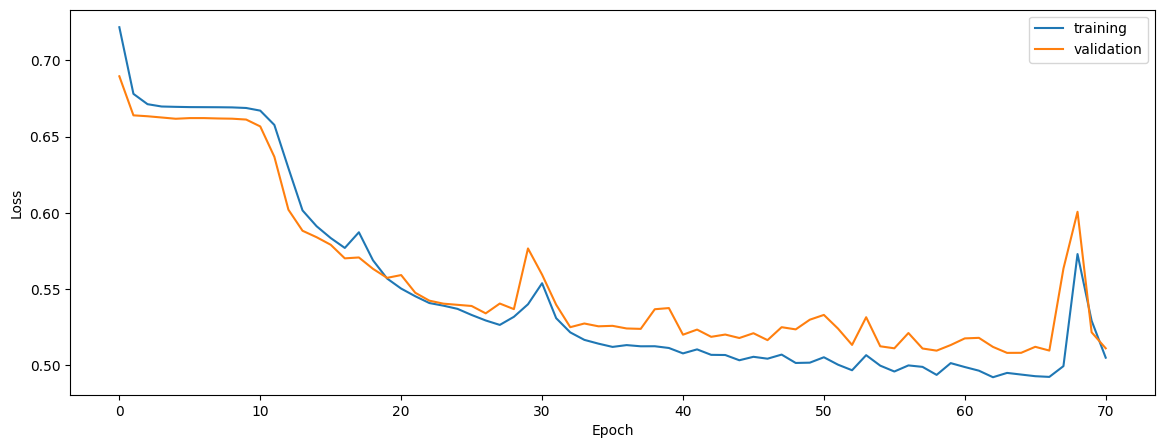

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

0.631670847996287
0.6030443139903372
0.5803231223579826


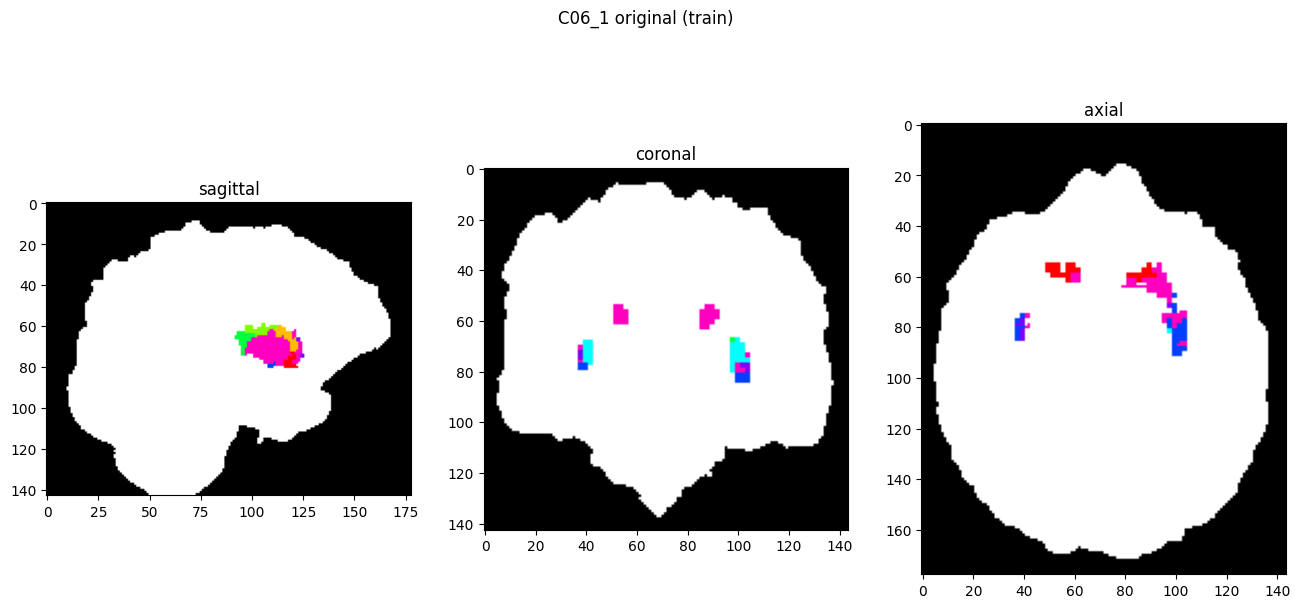

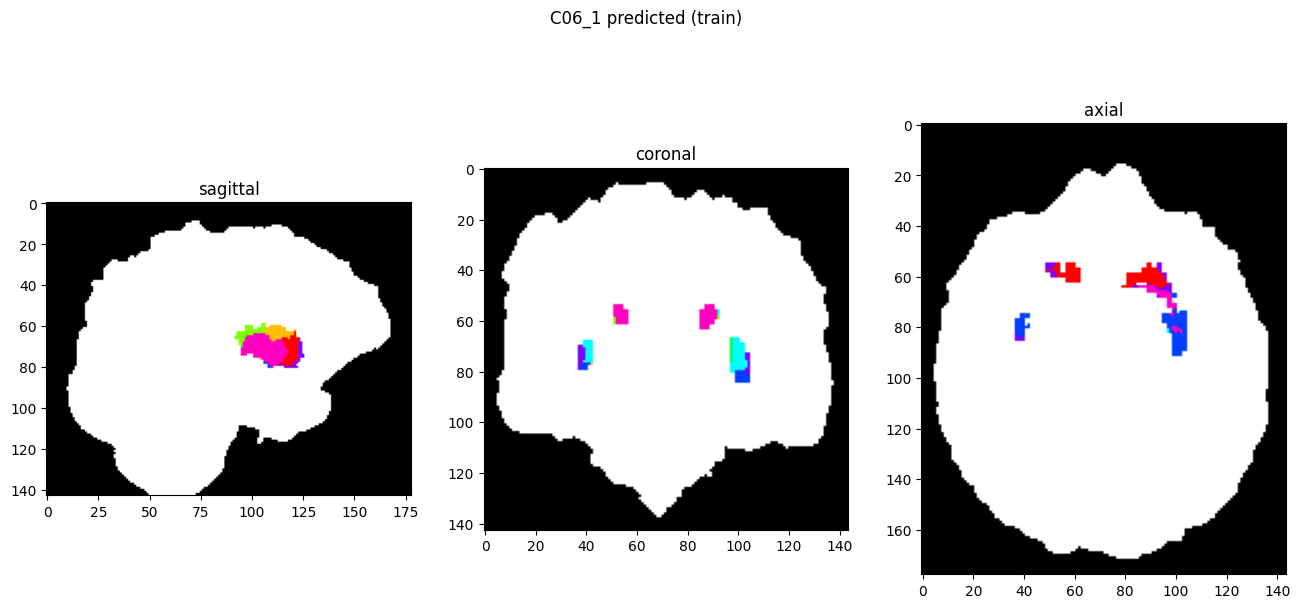

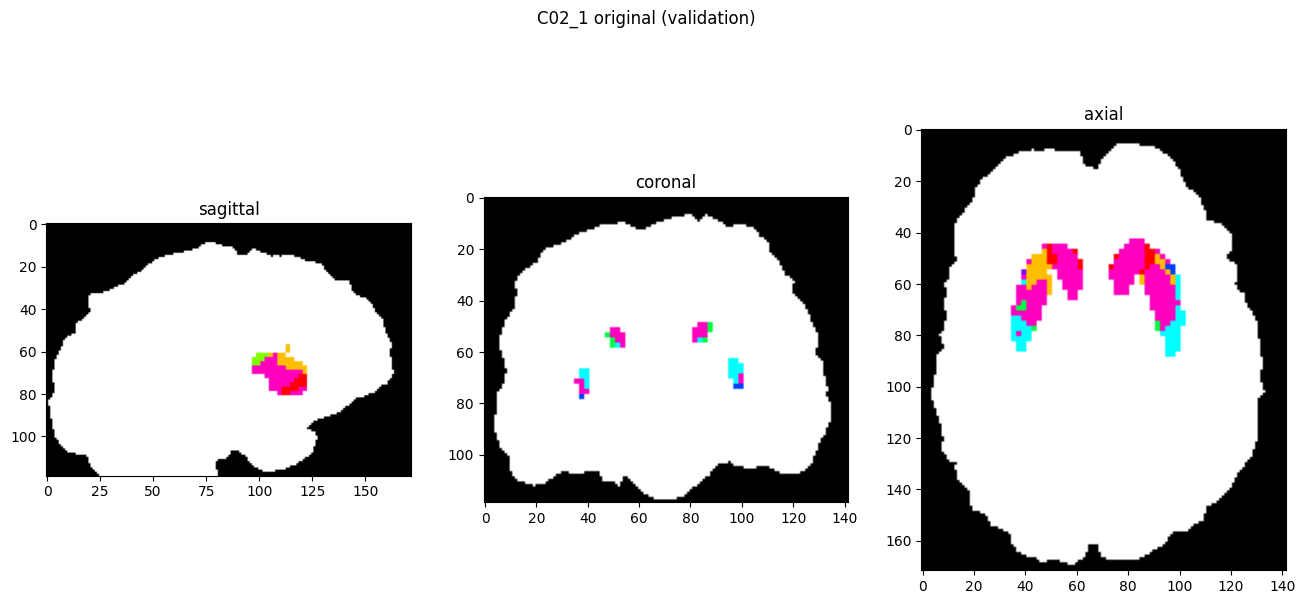

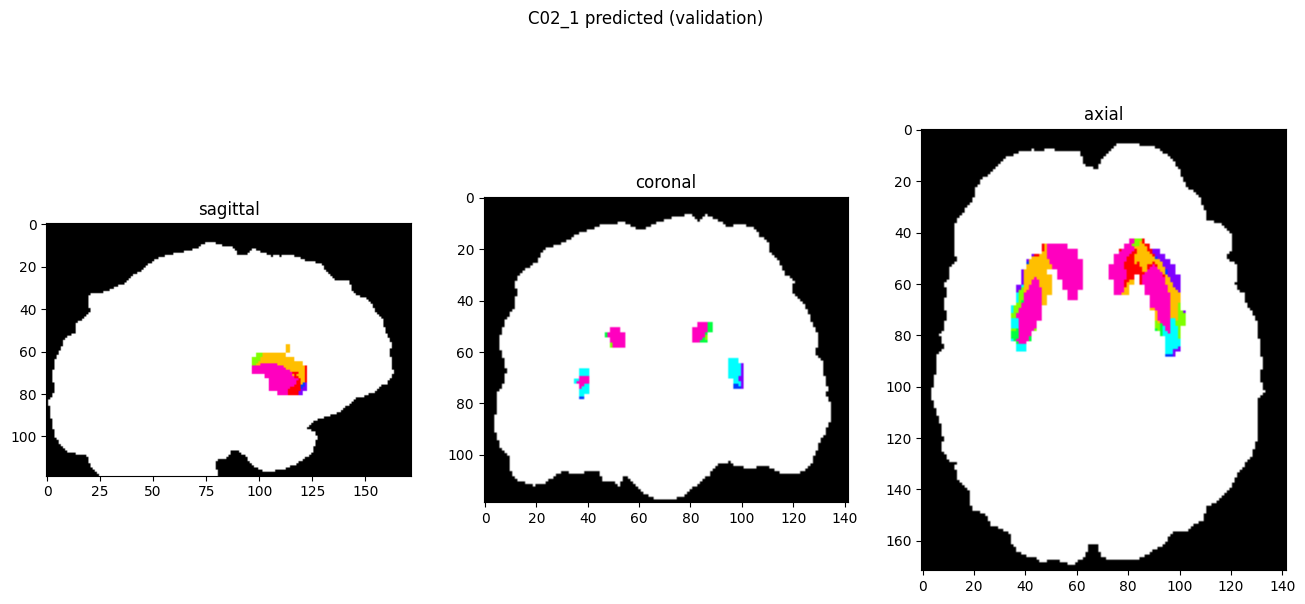

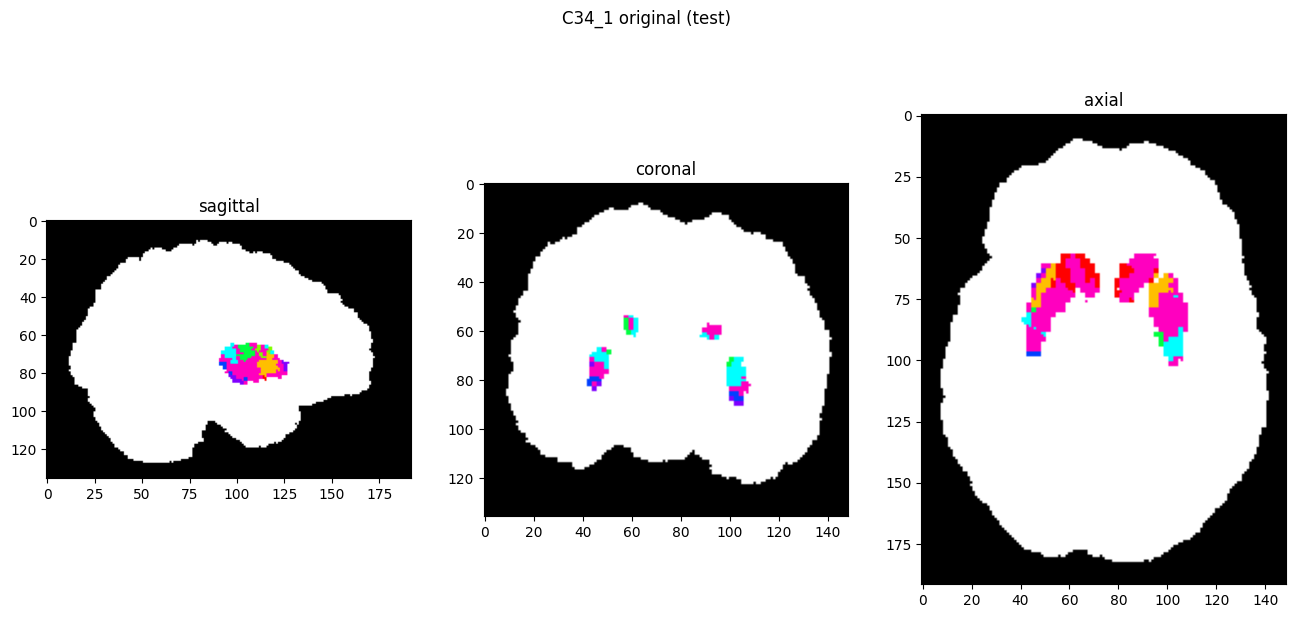

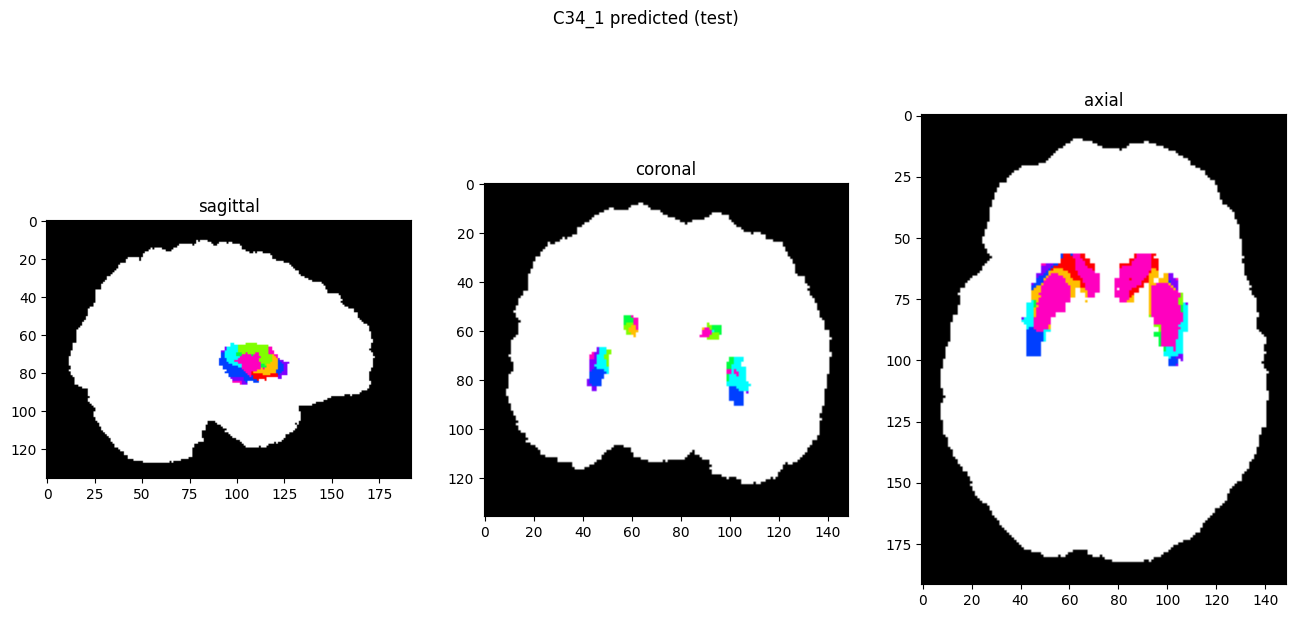

In [16]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)